# Genetic Algorithm Optimization for Relay Coordination (IEC)

This notebook implements a faithful adaptation of the MATLAB GA (Chu & Beasley style) used for relay setting optimization. It reads independent relay pairs, groups by scenario, runs GA per scenario, writes optimized values, updates pairs, and generates figures and a text report. All outputs are saved under `results/` and `data/processed/`.


In [1]:
# %% Imports and Constants (IEC / GA)
import os, json, math, random
from datetime import datetime, timezone
from pathlib import Path

# Plotting for inline diagnostics (optional)
import matplotlib
matplotlib.use("Agg")  # switch to inline later if needed
import matplotlib.pyplot as plt

# =============== CONSTANTS (aligned with MATLAB) ===============
K = 0.14
N = 0.02

CTI = 0.20
MIN_TDS = 0.05
MAX_TDS = 0.8
MIN_PICKUP = 0.05
MAX_PICKUP_FACTOR = 0.6
MAX_TIME = 10.0

# Heuristic placeholders (kept for signature compatibility)
MAX_ITERATIONS = 500
MIN_ALLOWED_INDIVIDUAL_MT = -0.009
CONVERGENCE_THRESHOLD_TMT = 0.005
STAGNATION_LIMIT = 25

# GA (Chu & Beasley) — matched to MATLAB
GA_Ni = 80
GA_iterno = 50000
GA_maxGen = 50000
GA_nMut = 2


In [2]:
# %% Utilities (paths, parsing, IEC time)

def _paths():
    nb_dir = Path.cwd()
    # Robust project root detection for portability
    if nb_dir.name == 'notebooks' and nb_dir.parent.name == 'analysis':
        project_root = nb_dir.parent.parent  # .../AutoDOC-MG
    elif nb_dir.name == 'analysis':
        project_root = nb_dir.parent
    else:
        project_root = nb_dir if (nb_dir / 'data').exists() else nb_dir.parent

    in_dir   = project_root / "data" / "raw"
    out_dir  = project_root / "data" / "processed"
    res_dir  = project_root / "results"
    # Prefer processed scenario_1 pairs exported by analysis notebook
    in_file  = out_dir / "automation_results_scenario_1.json"
    opt_file = out_dir / "optimized_relay_values_scenario_1_GA.json"
    pairs_out= out_dir / "automation_results_scenario_1_optimized.json"
    fig_dir  = res_dir / "figures"
    rep_dir  = res_dir / "reports"
    return project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir


def get_numeric_field(dct, names):
    for n in names:
        if n in dct:
            try:
                return float(dct[n])
            except Exception:
                pass
    return None


def store_initial_setting(initial, relay_info):
    name = str(relay_info.get("relay", "")).strip()
    if not name or name in initial:
        return
    tds = get_numeric_field(relay_info, ["TDS", "tds"])
    pu  = get_numeric_field(relay_info, ["pick_up", "pickup"])
    if tds is not None or pu is not None:
        initial[name] = {"TDS_initial": tds, "pickup_initial": pu}


def group_data_by_scenario(data_array):
    scenario_map = {}
    for entry in data_array:
        sid = entry.get("scenario_id")
        m   = entry.get("main_relay"); b = entry.get("backup_relay")
        if not sid or not m or not b:
            continue
        mname = str(m.get("relay", "")).strip()
        bname = str(b.get("relay", "")).strip()
        if not mname or not bname:
            continue
        im = get_numeric_field(m, ["Ishc", "I_shc", "Isc", "fault_current"])
        ib = get_numeric_field(b, ["Ishc", "I_shc", "Isc", "fault_current"])
        if not im or not ib or im <= 0 or ib <= 0:
            continue
        if sid not in scenario_map:
            scenario_map[sid] = {"pairs": [], "relays": [], "initial_settings": {}}
        scenario_map[sid]["pairs"].append({
            "main_relay": mname, "backup_relay": bname,
            "Ishc_main": im, "Ishc_backup": ib
        })
        if mname not in scenario_map[sid]["relays"]:
            scenario_map[sid]["relays"].append(mname)
        if bname not in scenario_map[sid]["relays"]:
            scenario_map[sid]["relays"].append(bname)
        store_initial_setting(scenario_map[sid]["initial_settings"], m)
        store_initial_setting(scenario_map[sid]["initial_settings"], b)
    return scenario_map


def time_iec(I, PU, TDS):
    if I is None or PU is None or TDS is None:
        return float("nan")
    try:
        M = I/PU
        denom = (M**N) - 1.0
        if denom <= 0:
            return float("inf")
        return (K*TDS)/denom
    except Exception:
        return float("nan")


In [3]:
# %% Genetic Algorithm (Chu & Beasley style)

def Genetico(scenarioID, scenarioData,
             K_, N_, CTI_,
             MIN_TDS_, MAX_TDS_, MIN_PICKUP_, MAX_PICKUP_FACTOR_, MAX_TIME_,
             *_unused):
    pairs = scenarioData["pairs"]
    relays= [r for r in scenarioData["relays"] if str(r).strip()]
    nR = len(relays)
    if nR == 0:
        print(f'Scenario "{scenarioID}" has no valid relays.')
        return {}

    idx = {relays[i]: i for i in range(nR)}

    # Min Isc per relay
    IscMin = [float("inf")]*nR
    for p in pairs:
        IscMin[idx[p["main_relay"]]]   = min(IscMin[idx[p["main_relay"]]],   p["Ishc_main"])
        IscMin[idx[p["backup_relay"]]] = min(IscMin[idx[p["backup_relay"]]], p["Ishc_backup"])

    # Bounds
    xmin = ([MIN_TDS_]*nR) + ([MIN_PICKUP_]*nR)
    xmax = ([MAX_TDS_]*nR) + ([MAX_PICKUP_FACTOR_*IscMin[i] for i in range(nR)])
    Nv   = 2*nR

    def relay_time(I, PU, TDS):
        if I <= PU:
            return MAX_TIME_*10.0  # penalty as in MATLAB
        t = TDS * (K_ / ((I/PU)**N_ - 1.0))
        return min(max(t,0.0), MAX_TIME_*10.0)

    def fitness(ind):
        tds = ind[:nR]; pu = ind[nR:]
        tmt = 0.0
        for p in pairs:
            mi = idx[p["main_relay"]]; bi = idx[p["backup_relay"]]
            tM = relay_time(p["Ishc_main"],   pu[mi], tds[mi])
            tB = relay_time(p["Ishc_backup"], pu[bi], tds[bi])
            if (tB - tM) < CTI_:
                tmt += (CTI_ - (tB - tM))
            if tM > MAX_TIME_:
                tmt += (tM - MAX_TIME_)
        return tmt

    # Initial population
    X = []
    for _ in range(GA_Ni):
        ind = [xmin[j] + random.random()*(xmax[j]-xmin[j]) for j in range(Nv)]
        X.append(ind + [fitness(ind)])
    X.sort(key=lambda r: r[Nv])
    X_best = X[0][:]
    print(f'    GA: generation 0  – TMT = {X_best[Nv]:.6f}')

    stall = 0
    for gen in range(1, GA_maxGen+1):
        s1, s2 = random.sample(range(GA_Ni), 2)
        P1 = X[s1][:Nv]; P2 = X[s2][:Nv]
        cp = random.randint(1, Nv-1)
        H1 = P1[:cp] + P2[cp:]
        H2 = P2[:cp] + P1[cp:]

        def mutate(ch):
            for m in random.sample(range(Nv), GA_nMut):
                ch[m] = xmin[m] + random.random()*(xmax[m]-xmin[m])
            return ch
        H1 = mutate(H1); H2 = mutate(H2)
        f1 = fitness(H1); f2 = fitness(H2)

        # Replacement (best of two children) if improves worst and not duplicate
        cand = [(H1,f1),(H2,f2)]
        cand.sort(key=lambda t: t[1])
        child, fchild = cand[0]
        if fchild < X[-1][Nv]:
            duplicate = any(all(abs(child[j]-X[k][j]) < 1e-12 for j in range(Nv)) for k in range(GA_Ni))
            if not duplicate:
                X[-1] = child + [fchild]

        X.sort(key=lambda r: r[Nv])
        if X[0][Nv] < X_best[Nv]:
            X_best = X[0][:]
            stall = 0
        else:
            stall += 1

        if gen % 50 == 0:
            print(f'    GA: generation {gen} – TMT = {X_best[Nv]:.6f}')
        if X_best[Nv] == 0.0:
            break
        if stall >= GA_iterno:
            print(f'    GA: stagnation ({GA_iterno} gen without improvement).')
            break

    print(f'    GA finished. Generations: {gen}  – Best TMT = {X_best[Nv]:.6f}')
    best = X_best[:Nv]; TDSbest = best[:nR]; PUbest = best[nR:]
    optimized = { relays[r]: {"TDS": round(TDSbest[r],5), "pickup": round(PUbest[r],5)} for r in range(nR) }
    return optimized


In [4]:
# %% Plotting and Text Report (matplotlib, non-blocking)

def plot_and_report_from_pairs(pairs_out_path, CTI_val, maxPairs, fig_dir, rep_dir, show=False):
    import matplotlib
    if not show:
        matplotlib.use("Agg")
    import matplotlib.pyplot as plt

    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    Path(rep_dir).mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    figureFile = Path(fig_dir) / f"MT_TDS_Pickup_optimized_{ts}.png"
    reportFile = Path(rep_dir) / f"results_MT_optimized_{ts}.txt"

    with open(pairs_out_path, "r", encoding="utf-8") as f:
        S = json.load(f)
    if not isinstance(S, list) or not S:
        raise RuntimeError("Empty or invalid JSON format (pairs).")

    rows = []
    for item in S:
        if "main_relay" not in item or "backup_relay" not in item:
            continue
        m = item["main_relay"]; b = item["backup_relay"]
        need = ("relay","TDS","pick_up","Time_out")
        if not all(k in m for k in need) or not all(k in b for k in need):
            continue
        pairID = f"{m['relay']}-{b['relay']}"
        dt = (b["Time_out"] - m["Time_out"]) - CTI_val
        MT = dt if dt < 0 else 0.0
        rows.append({
            "pairID": pairID,
            "TDSm": m["TDS"], "TDSb": b["TDS"],
            "PUm": m["pick_up"], "PUb": b["pick_up"],
            "TimeOutM": m["Time_out"], "TimeOutB": b["Time_out"],
            "MT": MT
        })
    if not rows:
        raise RuntimeError("No valid pairs to analyze.")

    rows.sort(key=lambda r: r["MT"])
    Tplot = rows[:min(maxPairs, len(rows))]
    xNums  = list(range(1, len(Tplot)+1))
    labels = [r["pairID"] for r in Tplot]

    f = plt.figure(figsize=(14, 8), facecolor="w")
    f.suptitle("Relay Coordination", y=0.99)
    gs = f.add_gridspec(2,1, hspace=0.10)

    axA = f.add_subplot(gs[0,0])
    MT_vals = [r["MT"] for r in Tplot]
    bars = axA.bar(range(len(Tplot)), MT_vals)
    for i, mt in enumerate(MT_vals):
        bars[i].set_color((0.20,0.60,0.20) if mt == 0 else (0.85,0.20,0.20))
    axA.axhline(0, color="k", linestyle="--")
    axA.text(0.01, 0.02, "CTI satisfied", transform=axA.transAxes, ha="left", fontstyle="italic")
    axA.set_ylabel("MT (s)")
    axA.set_title("Coordination Margin")
    axA.grid(True)
    axA.set_xticks([])

    axB = f.add_subplot(gs[1,0]); axB2 = axB.twinx()
    TDSm = [r["TDSm"] for r in Tplot]; TDSb = [r["TDSb"] for r in Tplot]
    PUm  = [r["PUm"]  for r in Tplot]; PUb  = [r["PUb"]  for r in Tplot]
    axB.plot(xNums, TDSm, "^-", linewidth=1.2, markerfacecolor=(0,0.45,0.74))
    axB.plot(xNums, TDSb, "v-", linewidth=1.2, markerfacecolor=(0.85,0.33,0.10))
    axB.set_ylabel("TDS")
    axB2.plot(xNums, PUm, "o--", linewidth=1.2, markerfacecolor="w")
    axB2.plot(xNums, PUb, "s--", linewidth=1.2, markerfacecolor="w")
    axB2.set_ylabel("Pickup (A)")
    axB.set_xticks(xNums); axB.set_xticklabels(labels, rotation=45)
    axB.set_xlabel("Main-Backup pair")
    axB.set_title("Settings TDS (solid) and Pickup (dashed)")
    axB.grid(True); axB.set_xlim(0.5, len(Tplot)+0.5)

    f.savefig(figureFile, dpi=300)
    print(f"Figure saved: {figureFile}")
    if show:
        plt.show()
    plt.close(f)

    coord   = [r["pairID"] for r in Tplot if r["MT"] == 0]
    uncoord = [r["pairID"] for r in Tplot if r["MT"] < 0]
    TMT     = sum(r["MT"] for r in Tplot)
    with open(reportFile, "w", encoding="utf-8") as fid:
        fid.write("RELAY COORDINATION REPORT\n\n")
        fid.write(f"File: {pairs_out_path}\n")
        fid.write(f"Date: {datetime.now()}\n")
        fid.write(f"CTI : {CTI_val:.2f} s\n\n")
        fid.write(f"Analyzed pairs         : {len(Tplot)}\n")
        fid.write(f"Coordinated (MT = 0)   : {len(coord)}\n")
        fid.write(f"Uncoordinated (MT < 0) : {len(uncoord)}\n")
        fid.write(f"Shown TMT              : {TMT:.6f} s\n\n")
        fid.write("--- UNCOORDINATED PAIRS ---\n")
        fid.write("(All coordinated)\n" if not uncoord else "\n".join(uncoord) + "\n")
    print(f"Report saved: {reportFile}")


In [5]:
# %% Driver: Load, group, optimize, update pairs, report

project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir = _paths()
print(f"Project root: {project_root}")
print(f"Input file : {in_file}")

# Load input
with open(in_file, "r", encoding="utf-8") as f:
    raw = json.load(f)
if not isinstance(raw, list):
    raise TypeError("Input JSON must be a list of objects")
print(f"Loaded {len(raw)} entries from JSON.")

# Group by scenario
scenarioMap = group_data_by_scenario(raw)
scenarioIDs = list(scenarioMap.keys())
if not scenarioIDs:
    raise RuntimeError("No valid scenarios found in input data")
print(f"Found scenarios: {', '.join(scenarioIDs)}")

# Optimize per scenario
allOptimized = {}
for sid in scenarioIDs:
    data = scenarioMap[sid]
    print(f"\n>>> Optimizing scenario: {sid} – Pairs: {len(data['pairs'])}, Relays: {len(data['relays'])}")
    if not data["pairs"]:
        print(f"Scenario '{sid}' with no valid pairs. Skipping…")
        continue
    opt = Genetico(sid, data, K, N, CTI, MIN_TDS, MAX_TDS, MIN_PICKUP, MAX_PICKUP_FACTOR, MAX_TIME,
                   MAX_ITERATIONS, MIN_ALLOWED_INDIVIDUAL_MT, CONVERGENCE_THRESHOLD_TMT, STAGNATION_LIMIT,
                   -CTI*0.75, 1.15, 0.90, 1.05, 0.02, 0.01)
    if opt:
        allOptimized[sid] = opt
        print(f"    Scenario '{sid}' optimized. {len(opt)} relays updated.")
    else:
        print(f"    Optimization produced no results for '{sid}'.")

# Save optimization results
Path(opt_file).parent.mkdir(parents=True, exist_ok=True)
out_list = []
for sid, vals in allOptimized.items():
    out_list.append({
        "scenario_id": sid,
        "timestamp": datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%S.%fZ"),
        "relay_values": vals
    })
with open(opt_file, "w", encoding="utf-8") as f:
    json.dump(out_list, f, indent=2, ensure_ascii=False)
print(f"\nOptimization results saved to: {opt_file}")

# Update pairs with optimal settings (IEC time)
with open(in_file, "r", encoding="utf-8") as f:
    pairs = json.load(f)
relayVals = out_list[0]["relay_values"] if out_list else {}
opt_map = { name: (vals["pickup"], vals["TDS"]) for name, vals in relayVals.items() }

updated = []
for p in pairs:
    # main
    rn = p["main_relay"]["relay"]
    if rn in opt_map:
        pu, tds = opt_map[rn]
        p["main_relay"]["pick_up"]  = pu
        p["main_relay"]["TDS"]      = tds
        Ishc_m = get_numeric_field(p["main_relay"], ["Ishc","I_shc","Isc","fault_current"])
        p["main_relay"]["Time_out"] = time_iec(Ishc_m, pu, tds)
    # backup
    rn = p["backup_relay"]["relay"]
    if rn in opt_map:
        pu, tds = opt_map[rn]
        p["backup_relay"]["pick_up"]  = pu
        p["backup_relay"]["TDS"]      = tds
        Ishc_b = get_numeric_field(p["backup_relay"], ["Ishc","I_shc","Isc","fault_current"])
        p["backup_relay"]["Time_out"] = time_iec(Ishc_b, pu, tds)
    updated.append(p)

with open(pairs_out, "w", encoding="utf-8") as f:
    json.dump(updated, f, indent=2, ensure_ascii=False)
print(f"✅ Final pairs file created: {pairs_out}")

# Plots + report
plot_and_report_from_pairs(str(pairs_out), CTI, 100, str(fig_dir), str(rep_dir), show=False)


Project root: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
Input file : /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/processed/automation_results_scenario_1.json
Loaded 100 entries from JSON.
Found scenarios: scenario_1

>>> Optimizing scenario: scenario_1 – Pairs: 100, Relays: 74
    GA: generation 0  – TMT = 43.063631
    GA: generation 50 – TMT = 38.431842
    GA: generation 100 – TMT = 34.915303
    GA: generation 150 – TMT = 32.925037
    GA: generation 200 – TMT = 32.925037
    GA: generation 250 – TMT = 32.925037
    GA: generation 300 – TMT = 32.925037
    GA: generation 350 – TMT = 31.368887
    GA: generation 400 – TMT = 30.705163
    GA: generation 450 – TMT = 27.809402
    GA: generation 500 – TMT = 26.989403
    GA: generation 550 – TMT = 25.874277
    GA: generation 600 – TMT = 25.874277
    GA: generation 650 – TMT = 24.246079
    GA: generation 700 – TMT = 23.817154
    GA: generation 750 – TMT = 21.497298
    GA: generation 800 – TMT = 21.016

In [6]:
# %% Comparison: Automation vs GA-optimized (metrics and settings)
from pathlib import Path
from datetime import datetime
import json
import math
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# Inputs/outputs (from earlier paths)
project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir = _paths()
orig_file = in_file  # data/processed/automation_results_scenario_1.json
opt_pairs_file = pairs_out  # data/processed/automation_results_scenario_1_optimized.json
opt_values_file = opt_file  # data/processed/optimized_relay_values_scenario_1_GA.json

# Helpers

def _load_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def compute_pair_stats(pairs_list, cti: float):
    total_valid = 0
    coordinated = 0
    uncoordinated = 0
    tmt_sum = 0.0
    deltas = []
    for p in pairs_list:
        m = p.get("main_relay", {})
        b = p.get("backup_relay", {})
        tm = m.get("Time_out", None)
        tb = b.get("Time_out", None)
        if not isinstance(tm, (int, float)) or not isinstance(tb, (int, float)):
            continue
        if tm < 0 or tb < 0:
            continue
        dt = (tb - tm) - cti
        deltas.append(dt)
        total_valid += 1
        if dt >= 0:
            coordinated += 1
        else:
            uncoordinated += 1
            tmt_sum += -dt  # accumulate miscoordination magnitude
    coord_pct = (coordinated / total_valid * 100.0) if total_valid else 0.0
    return {
        "total_pairs": total_valid,
        "coordinated": coordinated,
        "uncoordinated": uncoordinated,
        "coord_pct": coord_pct,
        "tmt": -tmt_sum * -1 + -0  # keep sign clarity; tmt_sum is positive magnitude
    }, deltas

def extract_initial_settings_from_raw(raw_list):
    initial = {}
    for e in raw_list:
        for k in ("main_relay", "backup_relay"):
            r = e.get(k) or {}
            name = str(r.get("relay", "")).strip()
            if not name or name in initial:
                continue
            tds = get_numeric_field(r, ["TDS", "tds"])
            pu  = get_numeric_field(r, ["pick_up", "pickup"])
            if tds is not None or pu is not None:
                initial[name] = {"TDS": tds, "pickup": pu}
    return initial

# Load
raw_pairs = _load_json(Path(orig_file))
opt_pairs = _load_json(Path(opt_pairs_file)) if Path(opt_pairs_file).exists() else []
opt_values = _load_json(Path(opt_values_file)) if Path(opt_values_file).exists() else []
opt_map = (opt_values[0]["relay_values"] if isinstance(opt_values, list) and opt_values else {})

# Metrics before/after
metrics_before, deltas_before = compute_pair_stats(raw_pairs, CTI)
metrics_after, deltas_after = compute_pair_stats(opt_pairs, CTI) if opt_pairs else ({"total_pairs":0,"coordinated":0,"uncoordinated":0,"coord_pct":0.0,"tmt":0.0}, [])

print("Automation vs GA (scenario_1)")
print(f"  Pairs: before={metrics_before['total_pairs']} after={metrics_after['total_pairs']}")
print(f"  Coordination (%): before={metrics_before['coord_pct']:.1f} after={metrics_after['coord_pct']:.1f}")
print(f"  Uncoordinated: before={metrics_before['uncoordinated']} after={metrics_after['uncoordinated']}")
print(f"  TMT (sum of deficits): before={sum([-d for d in deltas_before if d<0]):.6f} after={sum([-d for d in deltas_after if d<0]):.6f}")

# Settings comparison table (if we have initial settings)
initial_settings = extract_initial_settings_from_raw(raw_pairs)
rows = []
for relay_name, init_vals in initial_settings.items():
    ov = opt_map.get(relay_name)
    rows.append({
        "relay": relay_name,
        "TDS_initial": init_vals.get("TDS"),
        "TDS_optimized": (ov or {}).get("TDS"),
        "pickup_initial": init_vals.get("pickup"),
        "pickup_optimized": (ov or {}).get("pickup"),
    })

import pandas as pd
settings_df = pd.DataFrame(rows)
if not settings_df.empty:
    display(settings_df.head(20))
else:
    print("No initial settings found in automation file to compare.")

# Save CSV summary
tables_dir = Path(project_root) / "results" / "tables"
plots_dir = Path(project_root) / "results" / "figures"
tables_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)

summary = {
    "coord_pct_before": metrics_before["coord_pct"],
    "coord_pct_after": metrics_after["coord_pct"],
    "uncoord_before": metrics_before["uncoordinated"],
    "uncoord_after": metrics_after["uncoordinated"],
    "tmt_before": sum([-d for d in deltas_before if d<0]),
    "tmt_after": sum([-d for d in deltas_after if d<0])
}
summary_df = pd.DataFrame([summary])
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_path = tables_dir / f"scenario_1_automation_vs_ga_summary_{ts}.csv"
summary_df.to_csv(summary_path, index=False)
print(f"Summary CSV saved: {summary_path}")

# Plots: Δt histograms before/after, settings deltas
f, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].hist(deltas_before, bins=30, color="#d9534f")
axs[0].axvline(0, color="k", linestyle="--")
axs[0].set_title("Δt distribution – Automation (before)")
axs[0].set_xlabel("Δt = Tb - Tm - CTI (s)")
axs[0].set_ylabel("count")
axs[1].hist(deltas_after, bins=30, color="#5cb85c")
axs[1].axvline(0, color="k", linestyle="--")
axs[1].set_title("Δt distribution – GA optimized (after)")
axs[1].set_xlabel("Δt = Tb - Tm - CTI (s)")
plt.tight_layout()
comp_hist_path = plots_dir / f"scenario_1_dt_hist_before_after_{ts}.png"
f.savefig(comp_hist_path, dpi=300)
plt.close(f)
print(f"Figure saved: {comp_hist_path}")

if not settings_df.empty:
    # TDS and Pickup deltas per relay (bar)
    s_df = settings_df.dropna(subset=["TDS_optimized","pickup_optimized"], how="all").copy()
    if not s_df.empty:
        x = range(len(s_df))
        f2, ax2 = plt.subplots(2, 1, figsize=(14,8), sharex=True)
        ax2[0].bar(x, s_df["TDS_optimized"].values, color="#1f77b4", alpha=0.8, label="TDS optimized")
        ax2[0].bar(x, s_df["TDS_initial"].values, color="#ff7f0e", alpha=0.5, label="TDS initial")
        ax2[0].set_ylabel("TDS")
        ax2[0].set_title("Relay TDS: initial vs optimized")
        ax2[0].legend()
        ax2[0].grid(True, linestyle=":", alpha=0.4)

        ax2[1].bar(x, s_df["pickup_optimized"].values, color="#2ca02c", alpha=0.8, label="Pickup optimized")
        ax2[1].bar(x, s_df["pickup_initial"].values, color="#d62728", alpha=0.5, label="Pickup initial")
        ax2[1].set_ylabel("Pickup (A)")
        ax2[1].set_xlabel("Relay index")
        ax2[1].set_title("Relay pickup: initial vs optimized")
        ax2[1].legend()
        ax2[1].grid(True, linestyle=":", alpha=0.4)

        f2.tight_layout()
        comp_set_path = plots_dir / f"scenario_1_settings_initial_vs_optimized_{ts}.png"
        f2.savefig(comp_set_path, dpi=300)
        plt.close(f2)
        print(f"Figure saved: {comp_set_path}")
    else:
        print("No comparable settings to plot.")
else:
    print("Settings DataFrame empty; skipping settings plots.")



Automation vs GA (scenario_1)
  Pairs: before=100 after=100
  Coordination (%): before=12.0 after=100.0
  Uncoordinated: before=88 after=0
  TMT (sum of deficits): before=15.854300 after=0.000000


,relay,TDS_initial,TDS_optimized,pickup_initial,pickup_optimized
0,R38,0.05000,0.15392,0.17386,0.29839
1,R39,0.08837,0.43366,0.12595,0.19594
2,R55,0.11869,0.57638,0.05198,0.07943
3,R10,0.15058,0.43967,0.05151,0.49158
4,R9,0.15090,0.38480,0.05474,0.91163
5,R47,0.14041,0.68165,0.05151,0.12462
6,R48,0.14541,0.57331,0.04929,0.34908
7,R11,0.13272,0.44289,0.04929,0.34782
8,R49,0.13306,0.61192,0.02586,0.15904
9,R72,0.15182,0.64215,0.02907,0.26635


Summary CSV saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/tables/scenario_1_automation_vs_ga_summary_20251007_155718.csv
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_dt_hist_before_after_20251007_155718.png
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_settings_initial_vs_optimized_20251007_155718.png


In [7]:
# %% Per-pair comparison: before (automation) vs after (GA)
from pathlib import Path
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir = _paths()
orig_pairs = _load_json(Path(in_file))
opt_pairs = _load_json(Path(pairs_out)) if Path(pairs_out).exists() else []

# Build maps by pair key (main-backup relay names)
def _pair_key(entry):
    m = (entry.get("main_relay") or {}).get("relay")
    b = (entry.get("backup_relay") or {}).get("relay")
    return (str(m).strip(), str(b).strip()) if m and b else None

orig_map = {}
for e in orig_pairs:
    k = _pair_key(e)
    if not k:
        continue
    orig_map[k] = e

opt_map_pairs = {}
for e in opt_pairs:
    k = _pair_key(e)
    if not k:
        continue
    opt_map_pairs[k] = e

rows = []
for k, e0 in orig_map.items():
    e1 = opt_map_pairs.get(k)
    m0 = e0.get("main_relay", {}); b0 = e0.get("backup_relay", {})
    tm0 = m0.get("Time_out", None); tb0 = b0.get("Time_out", None)
    dt0 = (tb0 - tm0 - CTI) if isinstance(tm0, (int,float)) and isinstance(tb0, (int,float)) else None

    tm1 = tb1 = dt1 = None
    if e1:
        m1 = e1.get("main_relay", {}); b1 = e1.get("backup_relay", {})
        tm1 = m1.get("Time_out", None); tb1 = b1.get("Time_out", None)
        dt1 = (tb1 - tm1 - CTI) if isinstance(tm1, (int,float)) and isinstance(tb1, (int,float)) else None

    rows.append({
        "Main": k[0],
        "Backup": k[1],
        "Time_main_before": tm0,
        "Time_backup_before": tb0,
        "dt_before": dt0,
        "coord_before": ("YES" if (dt0 is not None and dt0 >= 0) else ("NO" if dt0 is not None else None)),
        "Time_main_after": tm1,
        "Time_backup_after": tb1,
        "dt_after": dt1,
        "coord_after": ("YES" if (dt1 is not None and dt1 >= 0) else ("NO" if dt1 is not None else None)),
        "improvement": (0.0 if (dt0 is None or dt1 is None) else (dt1 - dt0))  # positive => margin improved
    })

pairs_df = pd.DataFrame(rows)
if pairs_df.empty:
    print("No comparable pairs found for per-pair analysis.")
else:
    # Sort by worst dt_before then improvement
    view_df = pairs_df.copy()
    view_df["dt_before"] = pd.to_numeric(view_df["dt_before"], errors="coerce")
    view_df["dt_after"] = pd.to_numeric(view_df["dt_after"], errors="coerce")
    view_df["improvement"] = pd.to_numeric(view_df["improvement"], errors="coerce")
    view_df = view_df.sort_values(["dt_before", "improvement"], ascending=[True, False])
    display(view_df.head(25))

    # Save CSV
    tables_dir = Path(project_root) / "results" / "tables"
    tables_dir.mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = tables_dir / f"scenario_1_per_pair_before_after_{ts}.csv"
    view_df.to_csv(csv_path, index=False)
    print(f"Per-pair CSV saved: {csv_path}")

    # Plot: top 25 worst before and their after dt
    worst = view_df.head(min(25, len(view_df)))
    x = list(range(len(worst)))
    f, ax = plt.subplots(figsize=(14,6))
    ax.bar([i-0.2 for i in x], worst["dt_before"], width=0.4, color="#d9534f", label="dt before")
    ax.bar([i+0.2 for i in x], worst["dt_after"],  width=0.4, color="#5cb85c", label="dt after")
    ax.axhline(0, color="k", linestyle="--")
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r.Main}-{r.Backup}" for r in worst.itertuples()], rotation=45, ha="right")
    ax.set_ylabel("Δt = Tb - Tm - CTI (s)")
    ax.set_title("Top 25 worst pairs (before) and their after Δt")
    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.4)
    plots_dir = Path(project_root) / "results" / "figures"
    plots_dir.mkdir(parents=True, exist_ok=True)
    png_path = plots_dir / f"scenario_1_per_pair_dt_before_after_{ts}.png"
    f.tight_layout()
    f.savefig(png_path, dpi=300)
    plt.close(f)
    print(f"Figure saved: {png_path}")



,Main,Backup,Time_main_before,Time_backup_before,dt_before,coord_before,Time_main_after,Time_backup_after,dt_after,coord_after,improvement
62,R66,R67,0.2699,0.0857,-0.3842,NO,1.823151,2.051353,0.028202,YES,0.412402
86,R7,R6,0.2806,0.0969,-0.3837,NO,2.063536,2.328076,0.064540,YES,0.448240
15,R15,R14,0.2676,0.0945,-0.3731,NO,1.640564,1.853515,0.012951,YES,0.386051
85,R43,R44,0.2732,0.1067,-0.3665,NO,2.127775,2.682152,0.354377,YES,0.720877
69,R30,R29,0.2420,0.0899,-0.3521,NO,1.427918,2.101088,0.473171,YES,0.825271
13,R51,R52,0.2664,0.1217,-0.3447,NO,1.957807,2.344067,0.186259,YES,0.530959
93,R9,R8,0.2566,0.1300,-0.3266,NO,2.329066,3.133883,0.604818,YES,0.931418
91,R45,R46,0.2540,0.1562,-0.2978,NO,2.247980,3.486228,1.038248,YES,1.336048
96,R34,R8,0.2112,0.1335,-0.2777,NO,2.577832,3.370836,0.593005,YES,0.870705
98,R71,R14,0.1676,0.0969,-0.2707,NO,1.485988,1.996767,0.310778,YES,0.581478


Per-pair CSV saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/tables/scenario_1_per_pair_before_after_20251007_155720.csv
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_per_pair_dt_before_after_20251007_155720.png


TMT analysis (scenario_1)
  Signed TMT: before=-15.854300  after=0.000000
  Magnitude TMT: before=15.854300  after=0.000000
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_TMT_signed_before_after_20251007_155720.png
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_TMT_magnitude_before_after_20251007_155720.png
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_cumulative_miscoordination_20251007_155720.png
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_per_pair_scatter_dt_before_after_20251007_155720.png
Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_miscoordination_magnitude_hist_20251007_155720.png


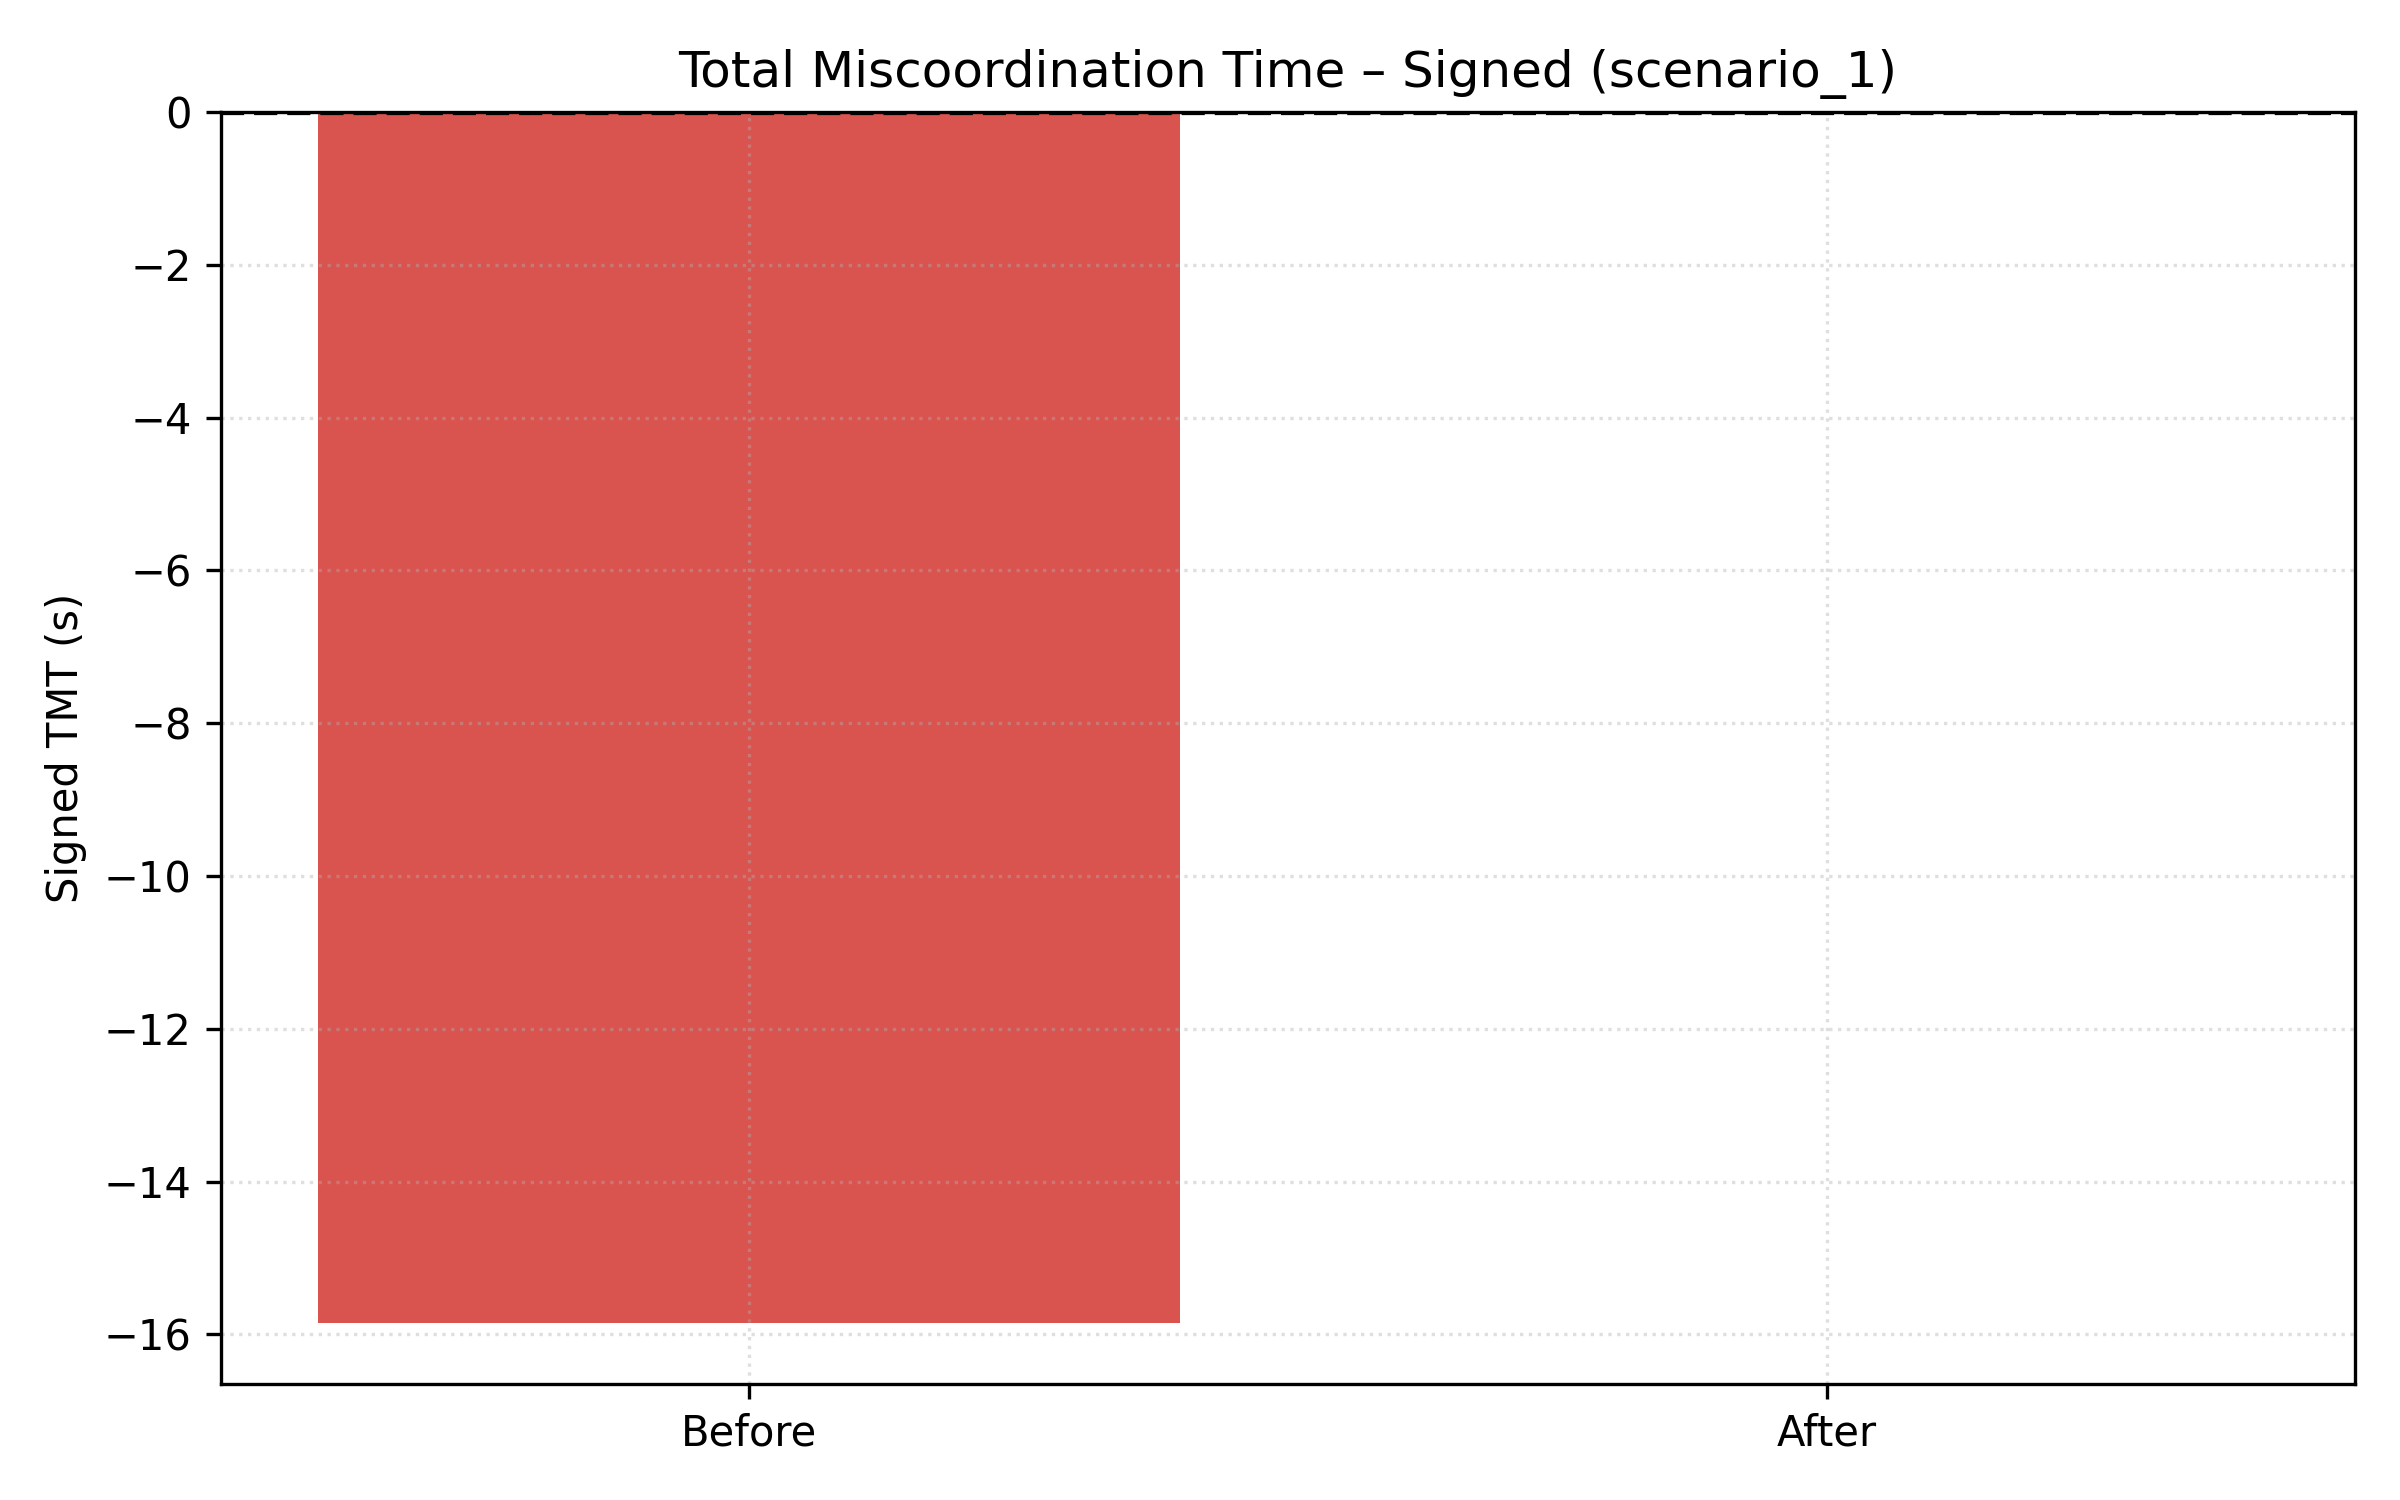

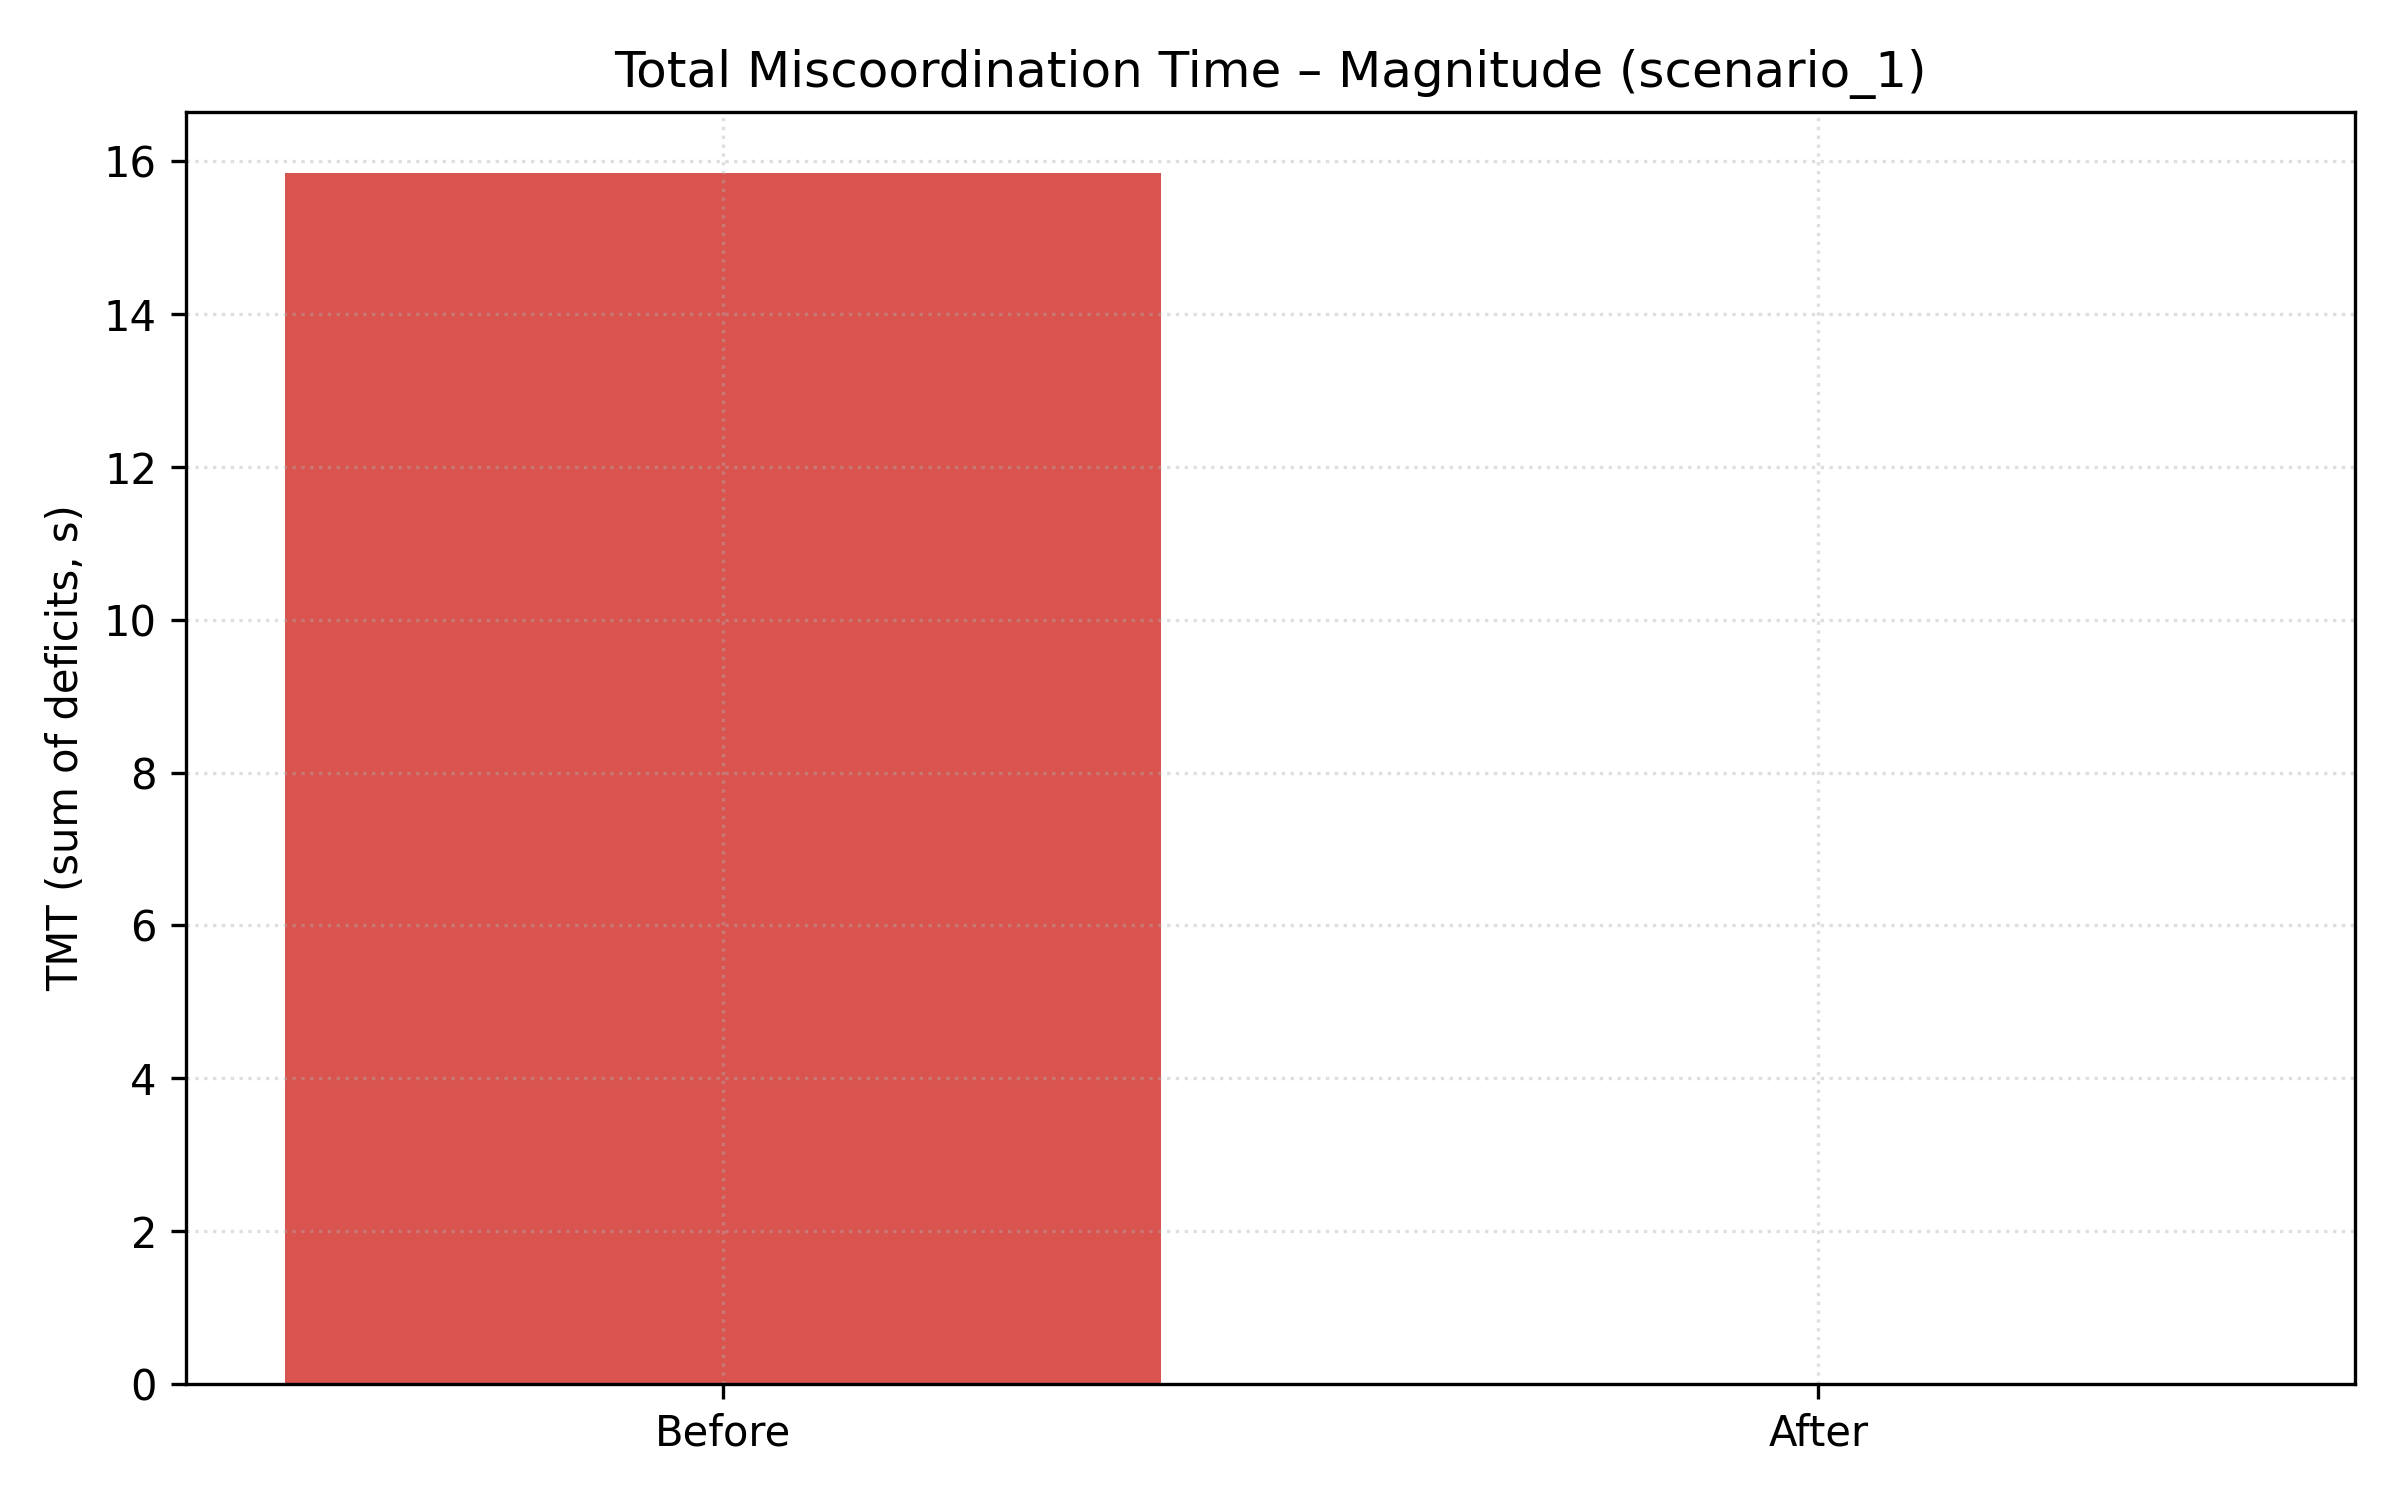

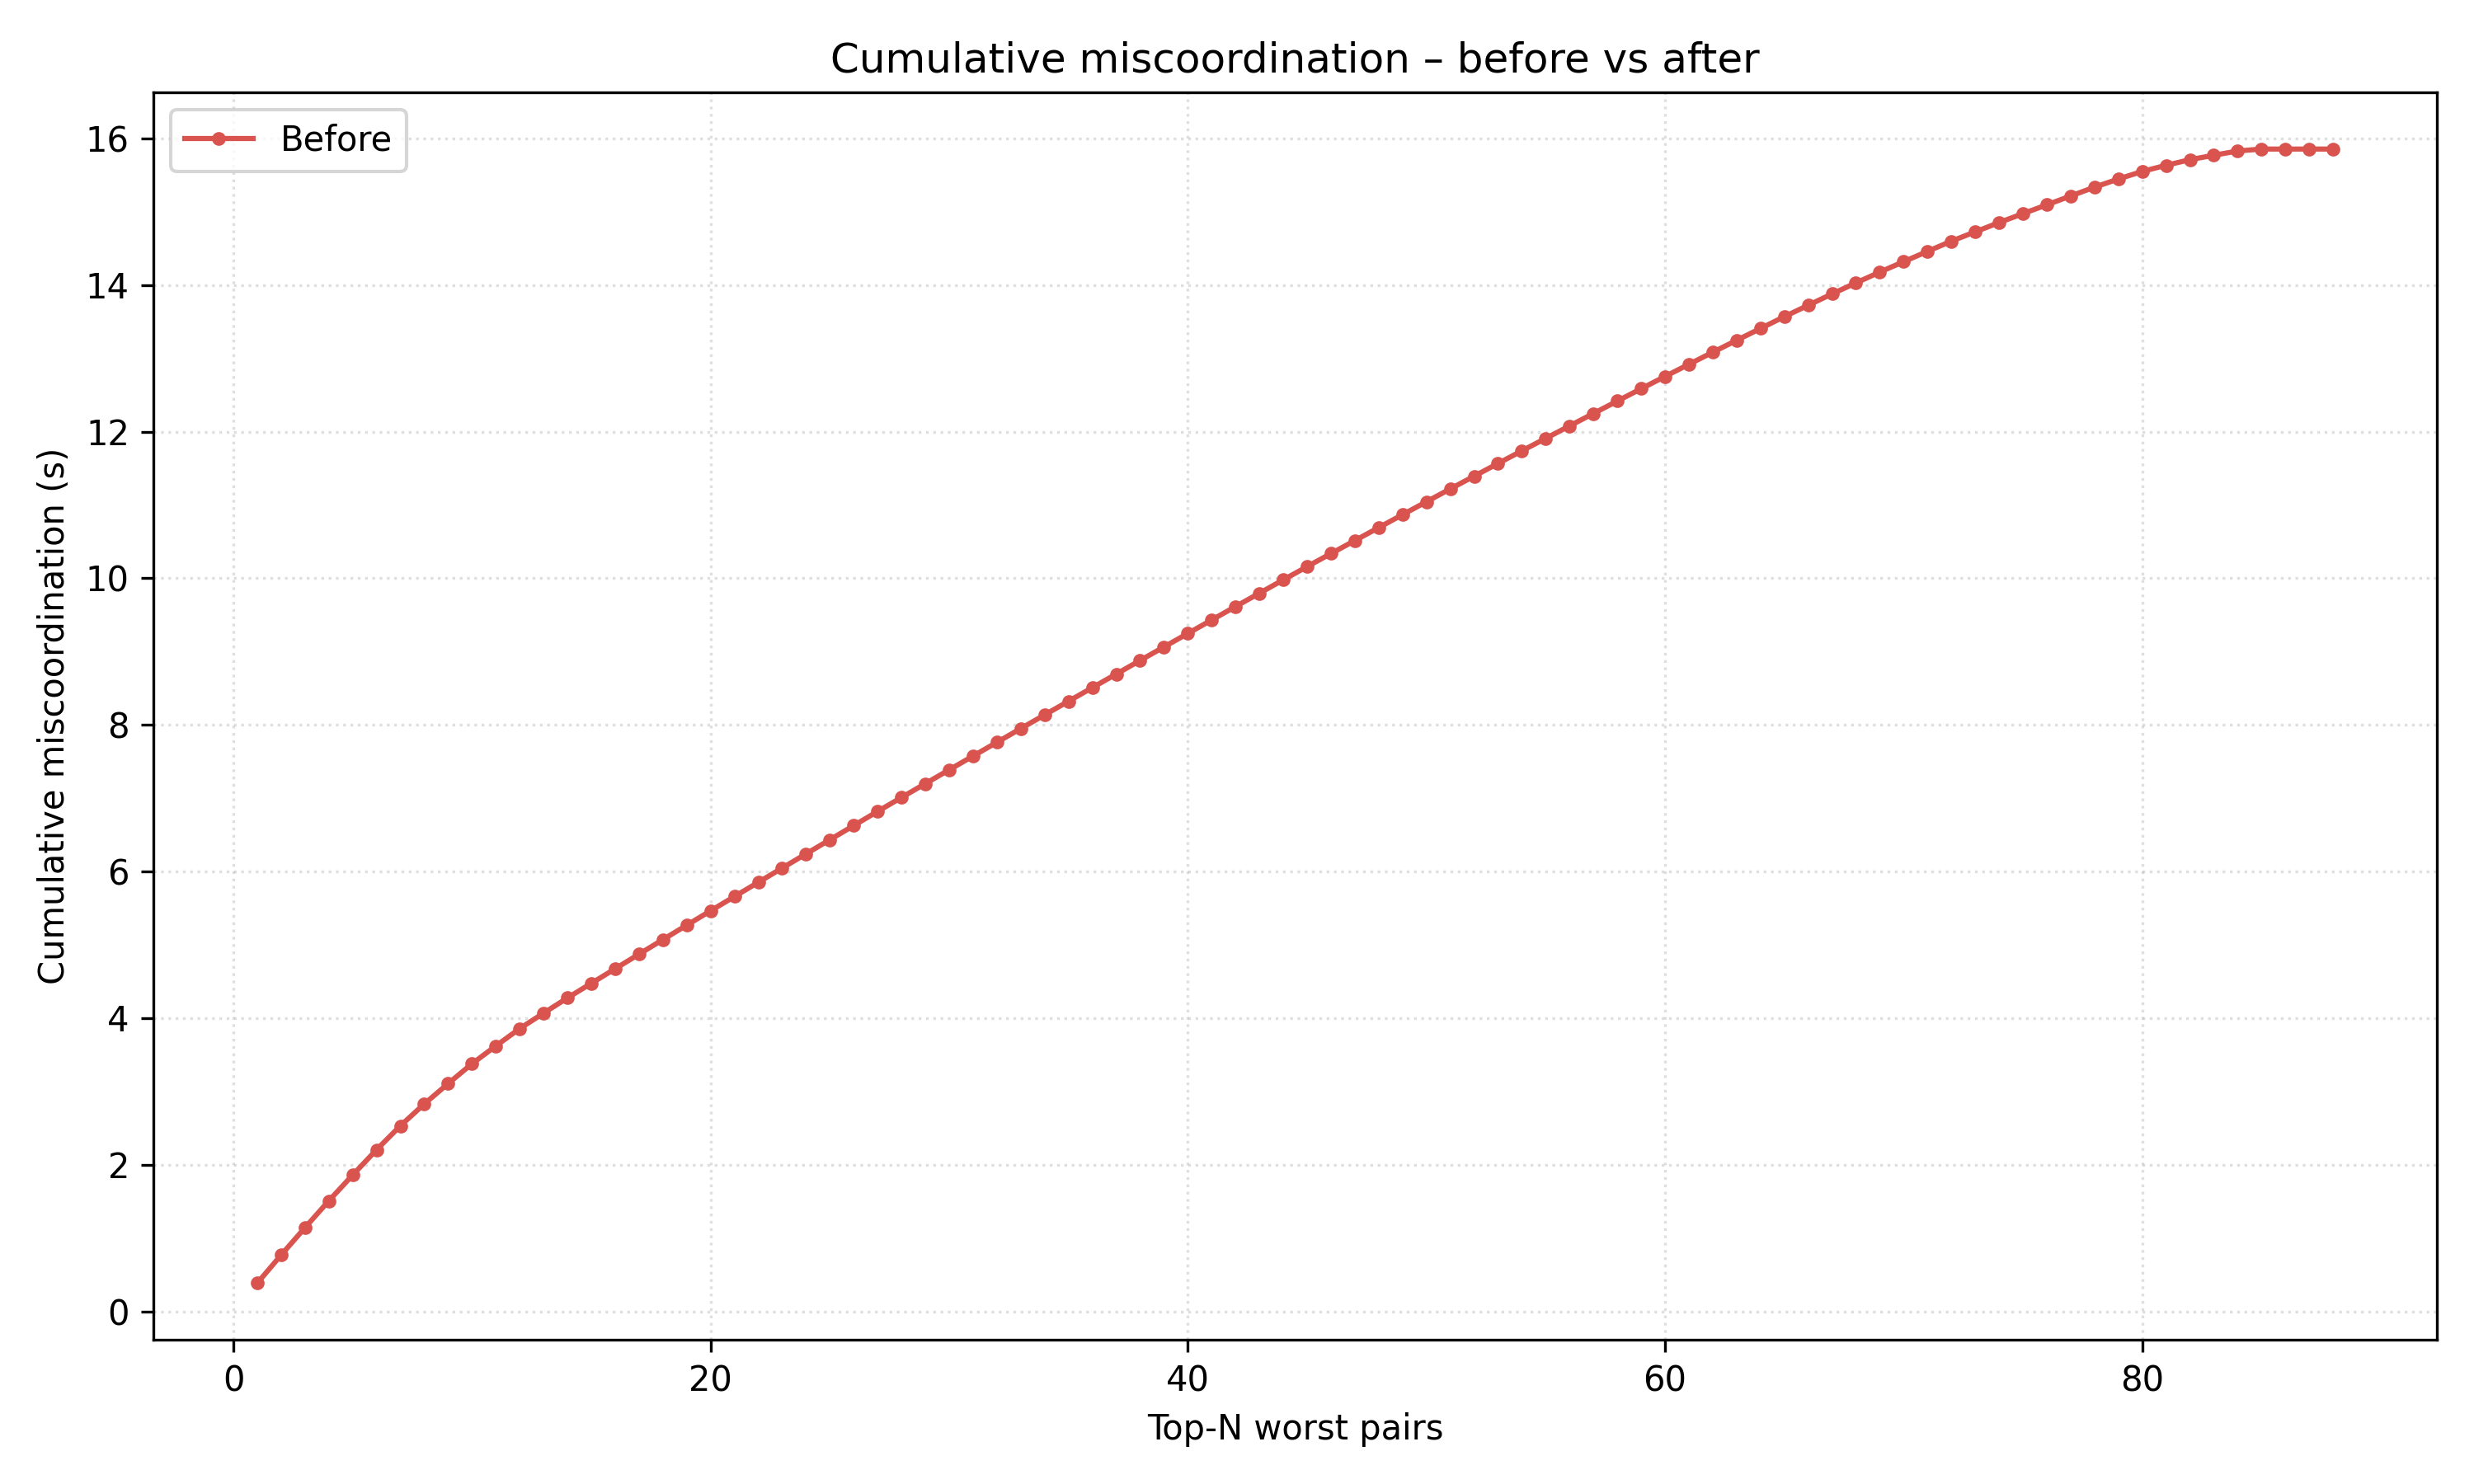

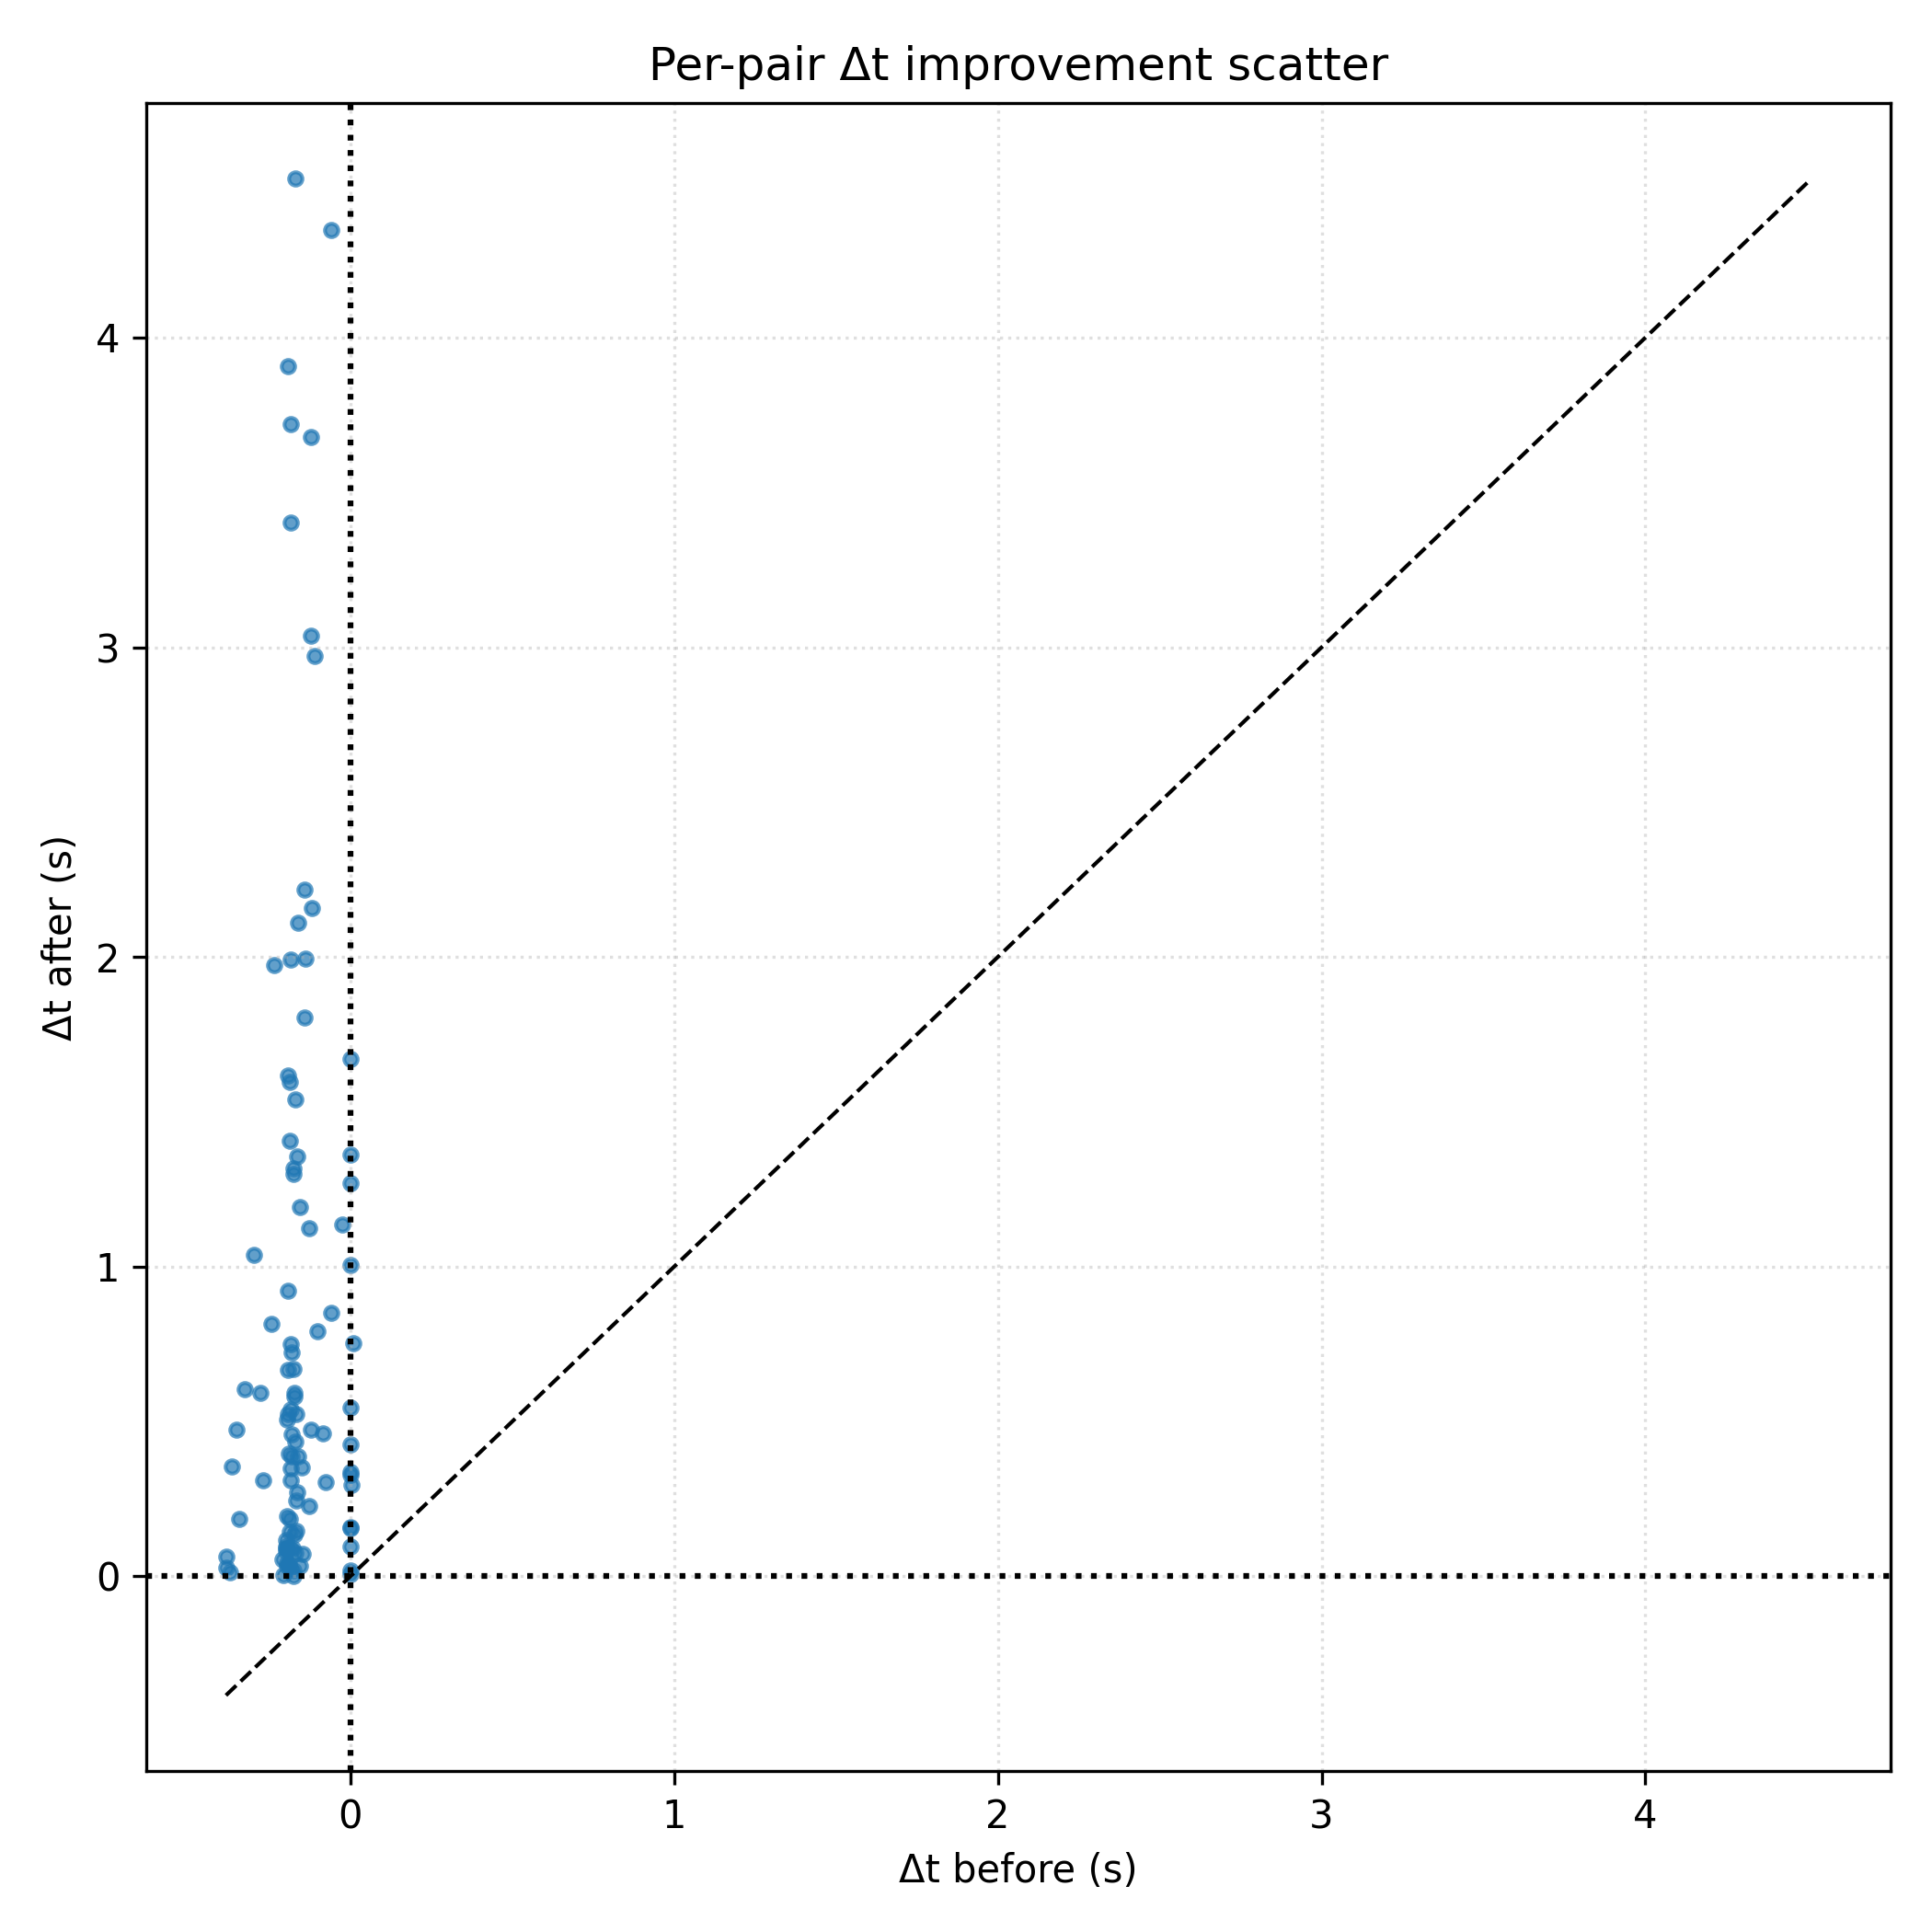

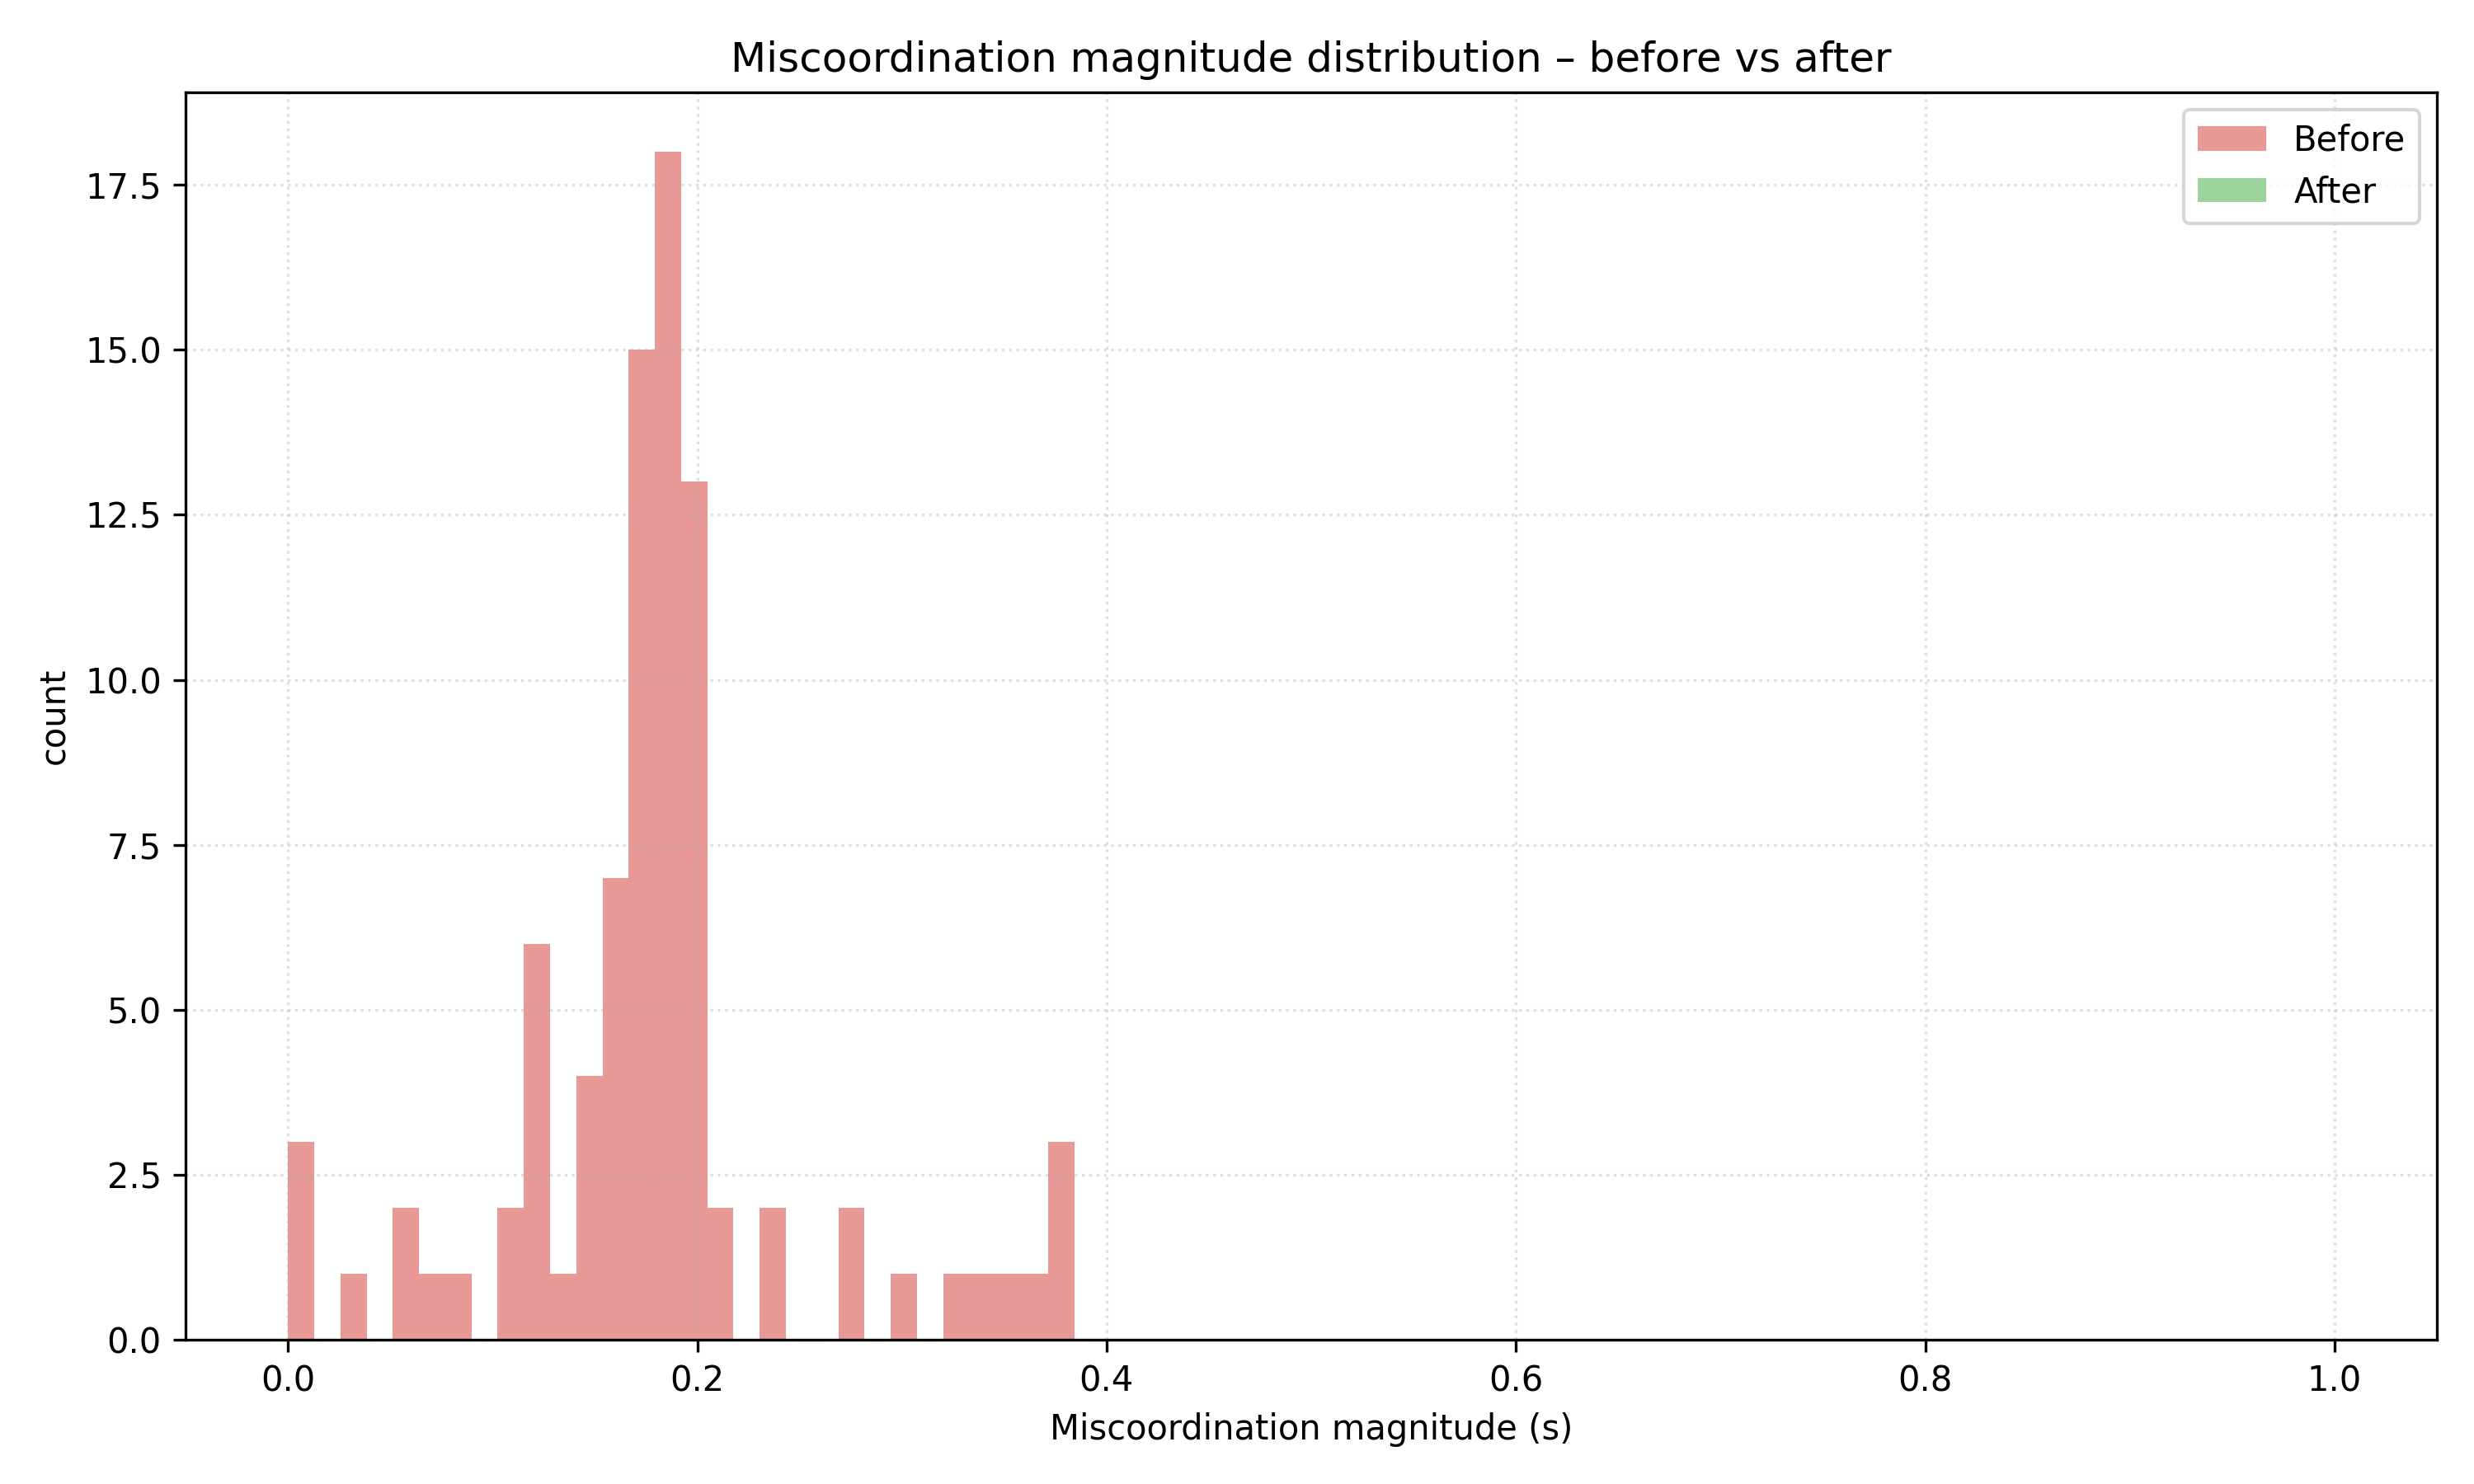

In [8]:
# %% TMT analysis and complementary figures (scenario_1)
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir = _paths()
orig_pairs = _load_json(Path(in_file))
opt_pairs = _load_json(Path(pairs_out)) if Path(pairs_out).exists() else []

# Compute deltas again to avoid dependency on previous cells

def _pair_deltas(pairs_list, cti: float):
    deltas = []
    for p in pairs_list:
        m = p.get("main_relay", {})
        b = p.get("backup_relay", {})
        tm = m.get("Time_out")
        tb = b.get("Time_out")
        if isinstance(tm, (int,float)) and isinstance(tb, (int,float)) and tm >= 0 and tb >= 0:
            deltas.append((tb - tm) - cti)
    return deltas

deltas_before = _pair_deltas(orig_pairs, CTI)
deltas_after  = _pair_deltas(opt_pairs, CTI) if opt_pairs else []

# TMT definitions
# Signed TMT (sum of negative dt values) matches the "-15..." observation
TMT_before_signed = float(np.sum([d for d in deltas_before if d < 0.0]))
TMT_after_signed  = float(np.sum([d for d in deltas_after  if d < 0.0])) if deltas_after else 0.0

# Magnitude TMT (sum of deficits as positive values)
TMT_before_mag = float(np.sum([-d for d in deltas_before if d < 0.0]))
TMT_after_mag  = float(np.sum([-d for d in deltas_after  if d < 0.0])) if deltas_after else 0.0

print("TMT analysis (scenario_1)")
print(f"  Signed TMT: before={TMT_before_signed:.6f}  after={TMT_after_signed:.6f}")
print(f"  Magnitude TMT: before={TMT_before_mag:.6f}  after={TMT_after_mag:.6f}")

# Prepare output dir
plots_dir = Path(project_root) / "results" / "figures"
plots_dir.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# (1) Bar chart: TMT before vs after (signed)
f1, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(["Before"], [TMT_before_signed], color="#d9534f")
ax1.bar(["After"],  [TMT_after_signed],  color="#5cb85c")
ax1.axhline(0, color="k", linestyle="--")
ax1.set_ylabel("Signed TMT (s)")
ax1.set_title("Total Miscoordination Time – Signed (scenario_1)")
ax1.grid(True, linestyle=":", alpha=0.4)
path1 = plots_dir / f"scenario_1_TMT_signed_before_after_{ts}.png"
f1.tight_layout(); f1.savefig(path1, dpi=300); plt.close(f1)
print(f"Figure saved: {path1}")

# (2) Bar chart: TMT before vs after (magnitude)
f2, ax2 = plt.subplots(figsize=(8,5))
ax2.bar(["Before"], [TMT_before_mag], color="#d9534f")
ax2.bar(["After"],  [TMT_after_mag],  color="#5cb85c")
ax2.set_ylabel("TMT (sum of deficits, s)")
ax2.set_title("Total Miscoordination Time – Magnitude (scenario_1)")
ax2.grid(True, linestyle=":", alpha=0.4)
path2 = plots_dir / f"scenario_1_TMT_magnitude_before_after_{ts}.png"
f2.tight_layout(); f2.savefig(path2, dpi=300); plt.close(f2)
print(f"Figure saved: {path2}")

# (3) Cumulative miscoordination curves (sorted deficits)
def _cum_curve(deltas):
    deficits = sorted([-d for d in deltas if d < 0.0], reverse=True)
    csum = np.cumsum(deficits) if deficits else []
    return deficits, csum

def_before, csum_before = _cum_curve(deltas_before)
def_after,  csum_after  = _cum_curve(deltas_after)

f3, ax3 = plt.subplots(figsize=(10,6))
ax3.plot(range(1, len(csum_before)+1), csum_before, "-o", ms=3, label="Before", color="#d9534f")
if len(csum_after):
    ax3.plot(range(1, len(csum_after)+1), csum_after,  "-o", ms=3, label="After",  color="#5cb85c")
ax3.set_xlabel("Top-N worst pairs")
ax3.set_ylabel("Cumulative miscoordination (s)")
ax3.set_title("Cumulative miscoordination – before vs after")
ax3.grid(True, linestyle=":", alpha=0.4)
ax3.legend()
path3 = plots_dir / f"scenario_1_cumulative_miscoordination_{ts}.png"
f3.tight_layout(); f3.savefig(path3, dpi=300); plt.close(f3)
print(f"Figure saved: {path3}")

# (4) Per-pair improvement scatter (dt_before vs dt_after)
# Build aligned pairs where both before and after are available
from collections import defaultdict

def _pair_key(e):
    m = (e.get("main_relay") or {}).get("relay")
    b = (e.get("backup_relay") or {}).get("relay")
    return (str(m).strip(), str(b).strip()) if m and b else None

orig_map = {}
for e in orig_pairs:
    k = _pair_key(e)
    if not k:
        continue
    m = e.get("main_relay", {}); b = e.get("backup_relay", {})
    tm = m.get("Time_out"); tb = b.get("Time_out")
    if isinstance(tm, (int,float)) and isinstance(tb, (int,float)):
        orig_map[k] = (tb - tm) - CTI

after_map = {}
for e in opt_pairs:
    k = _pair_key(e)
    if not k:
        continue
    m = e.get("main_relay", {}); b = e.get("backup_relay", {})
    tm = m.get("Time_out"); tb = b.get("Time_out")
    if isinstance(tm, (int,float)) and isinstance(tb, (int,float)):
        after_map[k] = (tb - tm) - CTI

xy = [(orig_map[k], after_map[k]) for k in orig_map.keys() if k in after_map]
xb = [p[0] for p in xy]; ya = [p[1] for p in xy]

f4, ax4 = plt.subplots(figsize=(7,7))
ax4.scatter(xb, ya, s=12, alpha=0.7)
lims = [min(xb+ya+[0]), max(xb+ya+[0])]
ax4.plot(lims, lims, 'k--', linewidth=1)
ax4.axvline(0, color='k', linestyle=':'); ax4.axhline(0, color='k', linestyle=':')
ax4.set_xlabel("Δt before (s)")
ax4.set_ylabel("Δt after (s)")
ax4.set_title("Per-pair Δt improvement scatter")
ax4.grid(True, linestyle=":", alpha=0.4)
path4 = plots_dir / f"scenario_1_per_pair_scatter_dt_before_after_{ts}.png"
f4.tight_layout(); f4.savefig(path4, dpi=300); plt.close(f4)
print(f"Figure saved: {path4}")

# (5) Overlay histograms of deficit magnitudes before/after
f5, ax5 = plt.subplots(figsize=(10,6))
ax5.hist([-d for d in deltas_before if d < 0.0], bins=30, alpha=0.6, label="Before", color="#d9534f")
if deltas_after:
    ax5.hist([-d for d in deltas_after if d < 0.0],  bins=30, alpha=0.6, label="After",  color="#5cb85c")
ax5.set_xlabel("Miscoordination magnitude (s)")
ax5.set_ylabel("count")
ax5.set_title("Miscoordination magnitude distribution – before vs after")
ax5.legend(); ax5.grid(True, linestyle=":", alpha=0.4)
path5 = plots_dir / f"scenario_1_miscoordination_magnitude_hist_{ts}.png"
f5.tight_layout(); f5.savefig(path5, dpi=300); plt.close(f5)
print(f"Figure saved: {path5}")

# Show figures inline in the notebook
try:
    from IPython.display import Image, display
    for p in [path1, path2, path3, path4, path5]:
        display(Image(filename=str(p)))
except Exception as _e:
    pass



Figure saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/scenario_1_per_pair_slope_before_after_20251007_155722.png


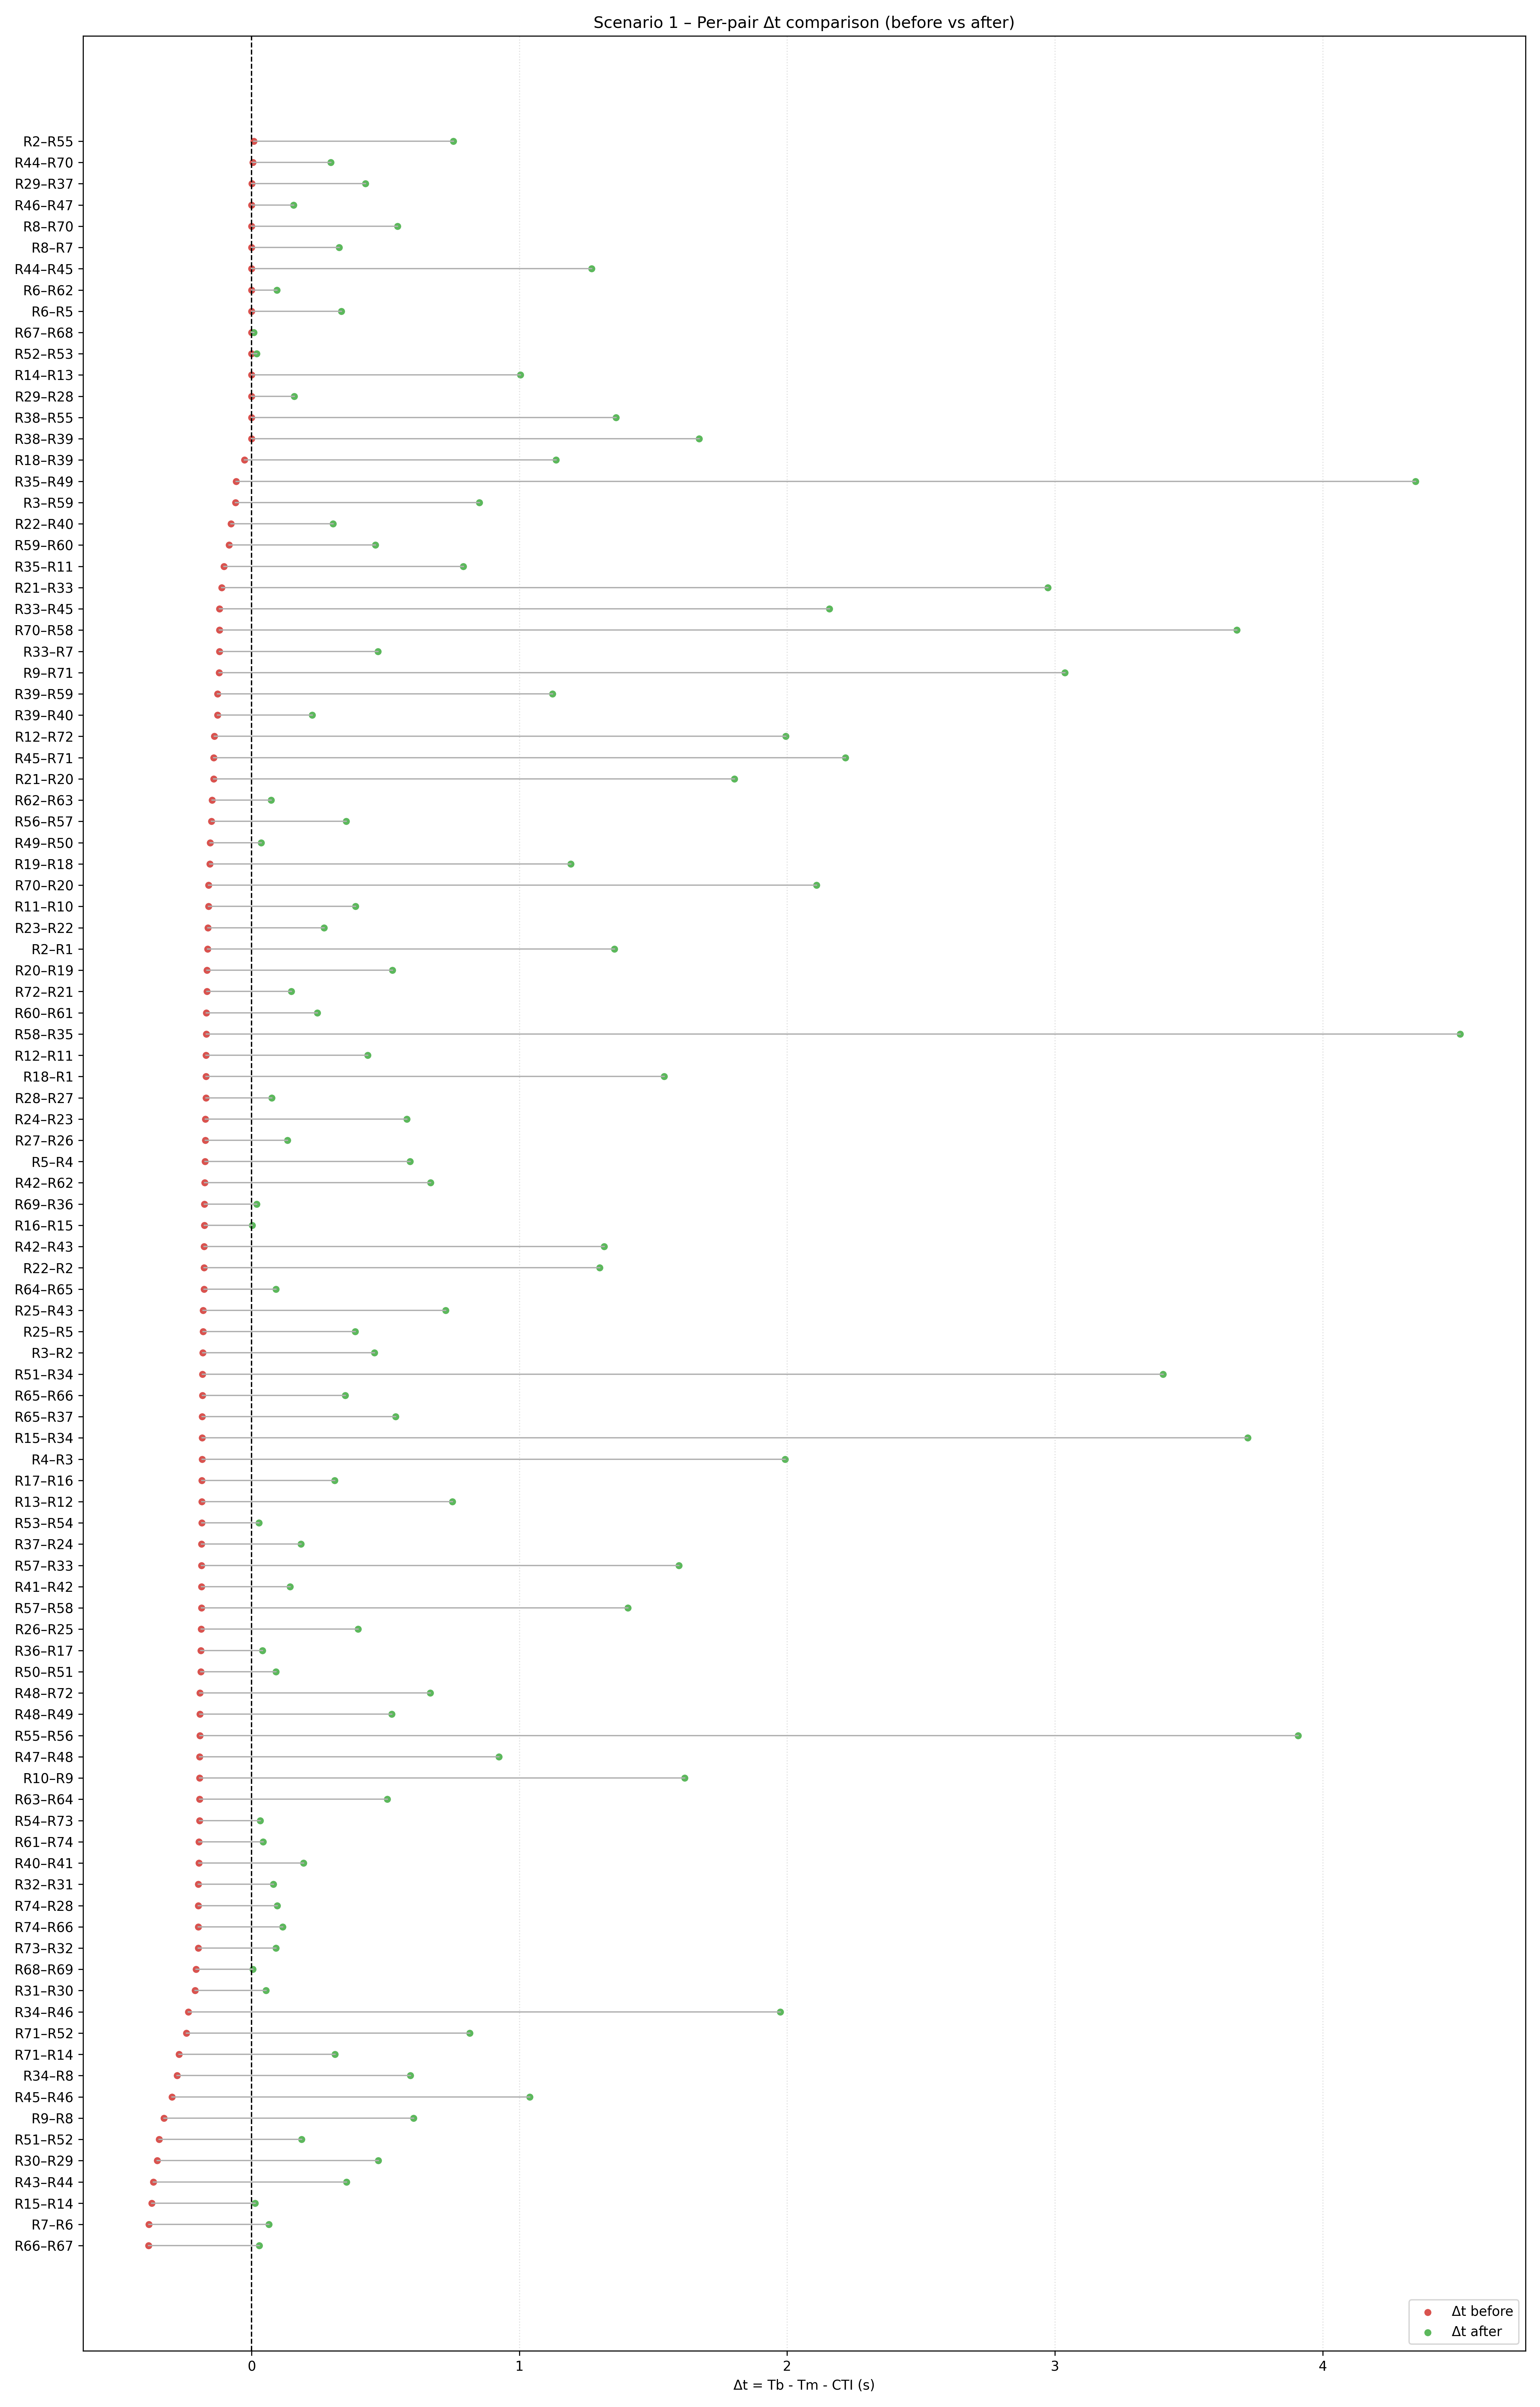

In [9]:
# %% Full per-pair comparison (all pairs): slope chart before vs after
from pathlib import Path
from datetime import datetime
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

project_root, in_file, opt_file, pairs_out, fig_dir, rep_dir = _paths()
orig_pairs = _load_json(Path(in_file))
opt_pairs = _load_json(Path(pairs_out)) if Path(pairs_out).exists() else []

# Build aligned per-pair list
def _pair_key(e):
    m = (e.get("main_relay") or {}).get("relay")
    b = (e.get("backup_relay") or {}).get("relay")
    return (str(m).strip(), str(b).strip()) if m and b else None

orig_map = {}
for e in orig_pairs:
    k = _pair_key(e)
    if not k:
        continue
    m = e.get("main_relay", {}); b = e.get("backup_relay", {})
    tm = m.get("Time_out"); tb = b.get("Time_out")
    if isinstance(tm, (int,float)) and isinstance(tb, (int,float)):
        orig_map[k] = (tb - tm) - CTI

after_map = {}
for e in opt_pairs:
    k = _pair_key(e)
    if not k:
        continue
    m = e.get("main_relay", {}); b = e.get("backup_relay", {})
    tm = m.get("Time_out"); tb = b.get("Time_out")
    if isinstance(tm, (int,float)) and isinstance(tb, (int,float)):
        after_map[k] = (tb - tm) - CTI

pairs = []
for k, dtb in orig_map.items():
    if k in after_map:
        dta = after_map[k]
        label = f"{k[0]}–{k[1]}"
        pairs.append((label, dtb, dta))

if not pairs:
    print("No pairs to compare.")
else:
    # Sort by dt_before ascending (worst at bottom for horizontal plot)
    pairs.sort(key=lambda t: t[1])
    labels = [p[0] for p in pairs]
    dt_before = [p[1] for p in pairs]
    dt_after  = [p[2] for p in pairs]

    n = len(pairs)
    height = max(8, int(0.25*n))
    fig, ax = plt.subplots(figsize=(16, height))

    y = list(range(n))
    # Draw connecting lines
    for i in range(n):
        ax.plot([dt_before[i], dt_after[i]], [i, i], color="#b0b0b0", linewidth=1)
    # Points
    ax.scatter(dt_before, y, color="#d9534f", label="Δt before", s=18)
    ax.scatter(dt_after,  y, color="#5cb85c", label="Δt after", s=18)

    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Δt = Tb - Tm - CTI (s)")
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title("Scenario 1 – Per-pair Δt comparison (before vs after)")
    ax.grid(True, axis="x", linestyle=":", alpha=0.4)
    ax.legend(loc="lower right")
    plt.tight_layout()

    plots_dir = Path(project_root) / "results" / "figures"
    plots_dir.mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = plots_dir / f"scenario_1_per_pair_slope_before_after_{ts}.png"
    fig.savefig(out_path, dpi=300)
    plt.close(fig)
    print(f"Figure saved: {out_path}")

    # Show inline
    try:
        from IPython.display import Image, display
        display(Image(filename=str(out_path)))
    except Exception:
        pass

